## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost.
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models.
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [ ]:
#%load_ext nb_black

import warnings
warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from numpy import percentile

# Library to split data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

# To tune model, get different metric scores, and split data
from sklearn import metrics
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    classification_report,
    #plot_confusion_matrix,
)

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To do hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# To supress scientific notations for a dataframe to 3 decimal points
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

## Loading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/Great Learning/6.0 Model Tuning/Project/Test.csv')
df_train = pd.read_csv('/content/drive/MyDrive/Great Learning/6.0 Model Tuning/Project/Train.csv')

#copying data to another variable to avoid any changes to original data
data_test = df_test.copy()
data_train = df_train.copy()

## Data Overview

The initial steps to get an overview of any dataset is to:
- observe the first few rows of the dataset, to check whether the dataset has been loaded properly or not
- get information about the number of rows and columns in the dataset
- find out the data types of the columns to ensure that data is stored in the preferred format and the value of each property is as expected.
- check the statistical summary of the dataset to get an overview of the numerical columns of the data

### Checking the shape of the dataset

In [ ]:
#the number of rows and columns in the training data
data_train.shape

(20000, 41)

* the train dataset has 41 attributes and 20,000 rows

In [ ]:
#number of rows and columns in the test data
data_test.shape

(5000, 41)

* the test dataset has 41 attributes and 5,000 rows

###checking first and last five rows of the train data

In [ ]:
#top 5 rows of train data
data_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
2,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0
3,1.618,1.888,7.046,-1.147,0.083,-1.530,0.207,-2.494,0.345,2.119,-3.053,0.460,2.705,-0.636,-0.454,-3.174,-3.404,-1.282,1.582,-1.952,-3.517,-1.206,-5.628,-1.818,2.124,5.295,4.748,-2.309,-3.963,-6.029,4.949,-3.584,-2.577,1.364,0.623,5.550,-1.527,0.139,3.101,-1.277,0
4,-0.111,3.872,-3.758,-2.983,3.793,0.545,0.205,4.849,-1.855,-6.220,1.998,4.724,0.709,-1.989,-2.633,4.184,2.245,3.734,-6.313,-5.380,-0.887,2.062,9.446,4.490,-3.945,4.582,-8.780,-3.383,5.107,6.788,2.044,8.266,6.629,-10.069,1.223,-3.230,1.687,-2.164,-3.645,6.510,0


In [ ]:
#last 5 rows of train data
data_train.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
19995,-2.071,-1.088,-0.796,-3.012,-2.288,2.807,0.481,0.105,-0.587,-2.899,8.868,1.717,1.358,-1.777,0.710,4.945,-3.100,-1.199,-1.085,-0.365,3.131,-3.948,-3.578,-8.139,-1.937,-1.328,-0.403,-1.735,9.996,6.955,-3.938,-8.274,5.745,0.589,-0.650,-3.043,2.216,0.609,0.178,2.928,1
19996,2.890,2.483,5.644,0.937,-1.381,0.412,-1.593,-5.762,2.150,0.272,-2.095,-1.526,0.072,-3.540,-2.762,-10.632,-0.495,1.720,3.872,-1.210,-8.222,2.121,-5.492,1.452,1.450,3.685,1.077,-0.384,-0.839,-0.748,-1.089,-4.159,1.181,-0.742,5.369,-0.693,-1.669,3.660,0.820,-1.987,0
19997,-3.897,-3.942,-0.351,-2.417,1.108,-1.528,-3.520,2.055,-0.234,-0.358,-3.782,2.180,6.112,1.985,-8.330,-1.639,-0.915,5.672,-3.924,2.133,-4.502,2.777,5.728,1.620,-1.700,-0.042,-2.923,-2.760,-2.254,2.552,0.982,7.112,1.476,-3.954,1.856,5.029,2.083,-6.409,1.477,-0.874,0
19998,-3.187,-10.052,5.696,-4.370,-5.355,-1.873,-3.947,0.679,-2.389,5.457,1.583,3.571,9.227,2.554,-7.039,-0.994,-9.665,1.155,3.877,3.524,-7.015,-0.132,-3.446,-4.801,-0.876,-3.812,5.422,-3.732,0.609,5.256,1.915,0.403,3.164,3.752,8.530,8.451,0.204,-7.130,4.249,-6.112,0
19999,-2.687,1.961,6.137,2.600,2.657,-4.291,-2.344,0.974,-1.027,0.497,-9.589,3.177,1.055,-1.416,-4.669,-5.405,3.720,2.893,2.329,1.458,-6.429,1.818,0.806,7.786,0.331,5.257,-4.867,-0.819,-5.667,-2.861,4.674,6.621,-1.989,-1.349,3.952,5.450,-0.455,-2.202,1.678,-1.974,0


###checking first and last five rows of the test data

In [ ]:
#top 5 rows of test data
data_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-0.613,-3.820,2.202,1.300,-1.185,-4.496,-1.836,4.723,1.206,-0.342,-5.123,1.017,4.819,3.269,-2.984,1.387,2.032,-0.512,-1.023,7.339,-2.242,0.155,2.054,-2.772,1.851,-1.789,-0.277,-1.255,-3.833,-1.505,1.587,2.291,-5.411,0.870,0.574,4.157,1.428,-10.511,0.455,-1.448,0
1,0.390,-0.512,0.527,-2.577,-1.017,2.235,-0.441,-4.406,-0.333,1.967,1.797,0.410,0.638,-1.390,-1.883,-5.018,-3.827,2.418,1.762,-3.242,-3.193,1.857,-1.708,0.633,-0.588,0.084,3.014,-0.182,0.224,0.865,-1.782,-2.475,2.494,0.315,2.059,0.684,-0.485,5.128,1.721,-1.488,0
2,-0.875,-0.641,4.084,-1.590,0.526,-1.958,-0.695,1.347,-1.732,0.466,-4.928,3.565,-0.449,-0.656,-0.167,-1.630,2.292,2.396,0.601,1.794,-2.120,0.482,-0.841,1.790,1.874,0.364,-0.169,-0.484,-2.119,-2.157,2.907,-1.319,-2.997,0.460,0.620,5.632,1.324,-1.752,1.808,1.676,0
3,0.238,1.459,4.015,2.534,1.197,-3.117,-0.924,0.269,1.322,0.702,-5.578,-0.851,2.591,0.767,-2.391,-2.342,0.572,-0.934,0.509,1.211,-3.260,0.105,-0.659,1.498,1.100,4.143,-0.248,-1.137,-5.356,-4.546,3.809,3.518,-3.074,-0.284,0.955,3.029,-1.367,-3.412,0.906,-2.451,0
4,5.828,2.768,-1.235,2.809,-1.642,-1.407,0.569,0.965,1.918,-2.775,-0.530,1.375,-0.651,-1.679,-0.379,-4.443,3.894,-0.608,2.945,0.367,-5.789,4.598,4.450,3.225,0.397,0.248,-2.362,1.079,-0.473,2.243,-3.591,1.774,-1.502,-2.227,4.777,-6.560,-0.806,-0.276,-3.858,-0.538,0


In [ ]:
#last 5 rows of test data
data_test.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
4995,-5.120,1.635,1.251,4.036,3.291,-2.932,-1.329,1.754,-2.985,1.249,-6.878,3.715,-2.512,-1.395,-2.554,-2.197,4.772,2.403,3.792,0.487,-2.028,1.778,3.668,11.375,-1.977,2.252,-7.319,1.907,-3.734,-0.012,2.120,9.979,0.063,0.217,3.036,2.109,-0.557,1.939,0.513,-2.694,0
4996,-5.172,1.172,1.579,1.220,2.530,-0.669,-2.618,-2.001,0.634,-0.579,-3.671,0.460,3.321,-1.075,-7.113,-4.356,-0.001,3.698,-0.846,-0.222,-3.645,0.736,0.926,3.278,-2.277,4.458,-4.543,-1.348,-1.779,0.352,-0.214,4.424,2.604,-2.152,0.917,2.157,0.467,0.470,2.197,-2.377,0
4997,-1.114,-0.404,-1.765,-5.879,3.572,3.711,-2.483,-0.308,-0.922,-2.999,-0.112,-1.977,-1.623,-0.945,-2.735,-0.813,0.610,8.149,-9.199,-3.872,-0.296,1.468,2.884,2.792,-1.136,1.198,-4.342,-2.869,4.124,4.197,3.471,3.792,7.482,-10.061,-0.387,1.849,1.818,-1.246,-1.261,7.475,0
4998,-1.703,0.615,6.221,-0.104,0.956,-3.279,-1.634,-0.104,1.388,-1.066,-7.970,2.262,3.134,-0.486,-3.498,-4.562,3.136,2.536,-0.792,4.398,-4.073,-0.038,-2.371,-1.542,2.908,3.215,-0.169,-1.541,-4.724,-5.525,1.668,-4.100,-5.949,0.550,-1.574,6.824,2.139,-4.036,3.436,0.579,0
4999,-0.604,0.960,-0.721,8.230,-1.816,-2.276,-2.575,-1.041,4.130,-2.731,-3.292,-1.674,0.465,-1.646,-5.263,-7.988,6.480,0.226,4.963,6.752,-6.306,3.271,1.897,3.271,-0.637,-0.925,-6.759,2.990,-0.814,3.499,-8.435,2.370,-1.062,0.791,4.952,-7.441,-0.070,-0.918,-2.291,-5.363,0


### Checking the data types of the columns for the dataset

In [ ]:
#data_train types
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

* there are a total of 41 columns and 20,000 observations in the dataset
* V1 and V2 have missing values

In [ ]:
#data_test types
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 non-null   float64
 22  

* there are a total of 41 columns and 5,000 observations in the test dataset
* V1 and V2 have missing values

all the dependent variables except for target are floats in both train and test data

### Checking for duplicate values

In [ ]:
#checking for duplicates in train data
data_train.duplicated().sum()

0

In [ ]:
#checking for duplicates of test data
data_test.duplicated().sum()

0

### Checking for missing values

In [ ]:
#checking for missing values in train data
print(data_train.isnull().sum())

V1        18
V2        18
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64


In [ ]:
#checking for missing values in test data
print(data_test.isnull().sum())

V1        5
V2        6
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
V29       0
V30       0
V31       0
V32       0
V33       0
V34       0
V35       0
V36       0
V37       0
V38       0
V39       0
V40       0
Target    0
dtype: int64


both train and test data have missing values, so will need to perform missing values treatment

### Statistical summary of the dataset

In [ ]:
#statistical summary of the train data
data_train.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,19982.000,-0.272,3.442,-11.876,-2.737,-0.748,1.840,15.493
V2,19982.000,0.440,3.151,-12.320,-1.641,0.472,2.544,13.089
V3,20000.000,2.485,3.389,-10.708,0.207,2.256,4.566,17.091
V4,20000.000,-0.083,3.432,-15.082,-2.348,-0.135,2.131,13.236
V5,20000.000,-0.054,2.105,-8.603,-1.536,-0.102,1.340,8.134
V6,20000.000,-0.995,2.041,-10.227,-2.347,-1.001,0.380,6.976
V7,20000.000,-0.879,1.762,-7.950,-2.031,-0.917,0.224,8.006
V8,20000.000,-0.548,3.296,-15.658,-2.643,-0.389,1.723,11.679
V9,20000.000,-0.017,2.161,-8.596,-1.495,-0.068,1.409,8.138
V10,20000.000,-0.013,2.193,-9.854,-1.411,0.101,1.477,8.108


In the train dataset,
* V2, V3, V12, V13, V18, V19, V20, V22, V24, V26, V31, V32, V35, V36, V37, V39, and Target have positive means
*  V3 has the highest mean
* V21 has the lowest mean
* V32 has the highest standard deviation

In [ ]:
#statistical summary of the test data
data_test.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,4995.000,-0.278,3.466,-12.382,-2.744,-0.765,1.831,13.504
V2,4994.000,0.398,3.140,-10.716,-1.649,0.427,2.444,14.079
V3,5000.000,2.552,3.327,-9.238,0.315,2.260,4.587,15.315
V4,5000.000,-0.049,3.414,-14.682,-2.293,-0.146,2.166,12.140
V5,5000.000,-0.080,2.111,-7.712,-1.615,-0.132,1.341,7.673
V6,5000.000,-1.042,2.005,-8.924,-2.369,-1.049,0.308,5.068
V7,5000.000,-0.908,1.769,-8.124,-2.054,-0.940,0.212,7.616
V8,5000.000,-0.575,3.332,-12.253,-2.642,-0.358,1.713,10.415
V9,5000.000,0.030,2.174,-6.785,-1.456,-0.080,1.450,8.851
V10,5000.000,0.019,2.145,-8.171,-1.353,0.166,1.511,6.599


In the test dataset,
* V2, V3, V9, V10, V12, V13, V18, V19, V20, V22, V24, V25, V26, V31, V32, V35, V36, V37, V39, and Target have positive means
*  V35 has the highest mean
* V21 has the lowest mean
* V32 has the highest standard deviation

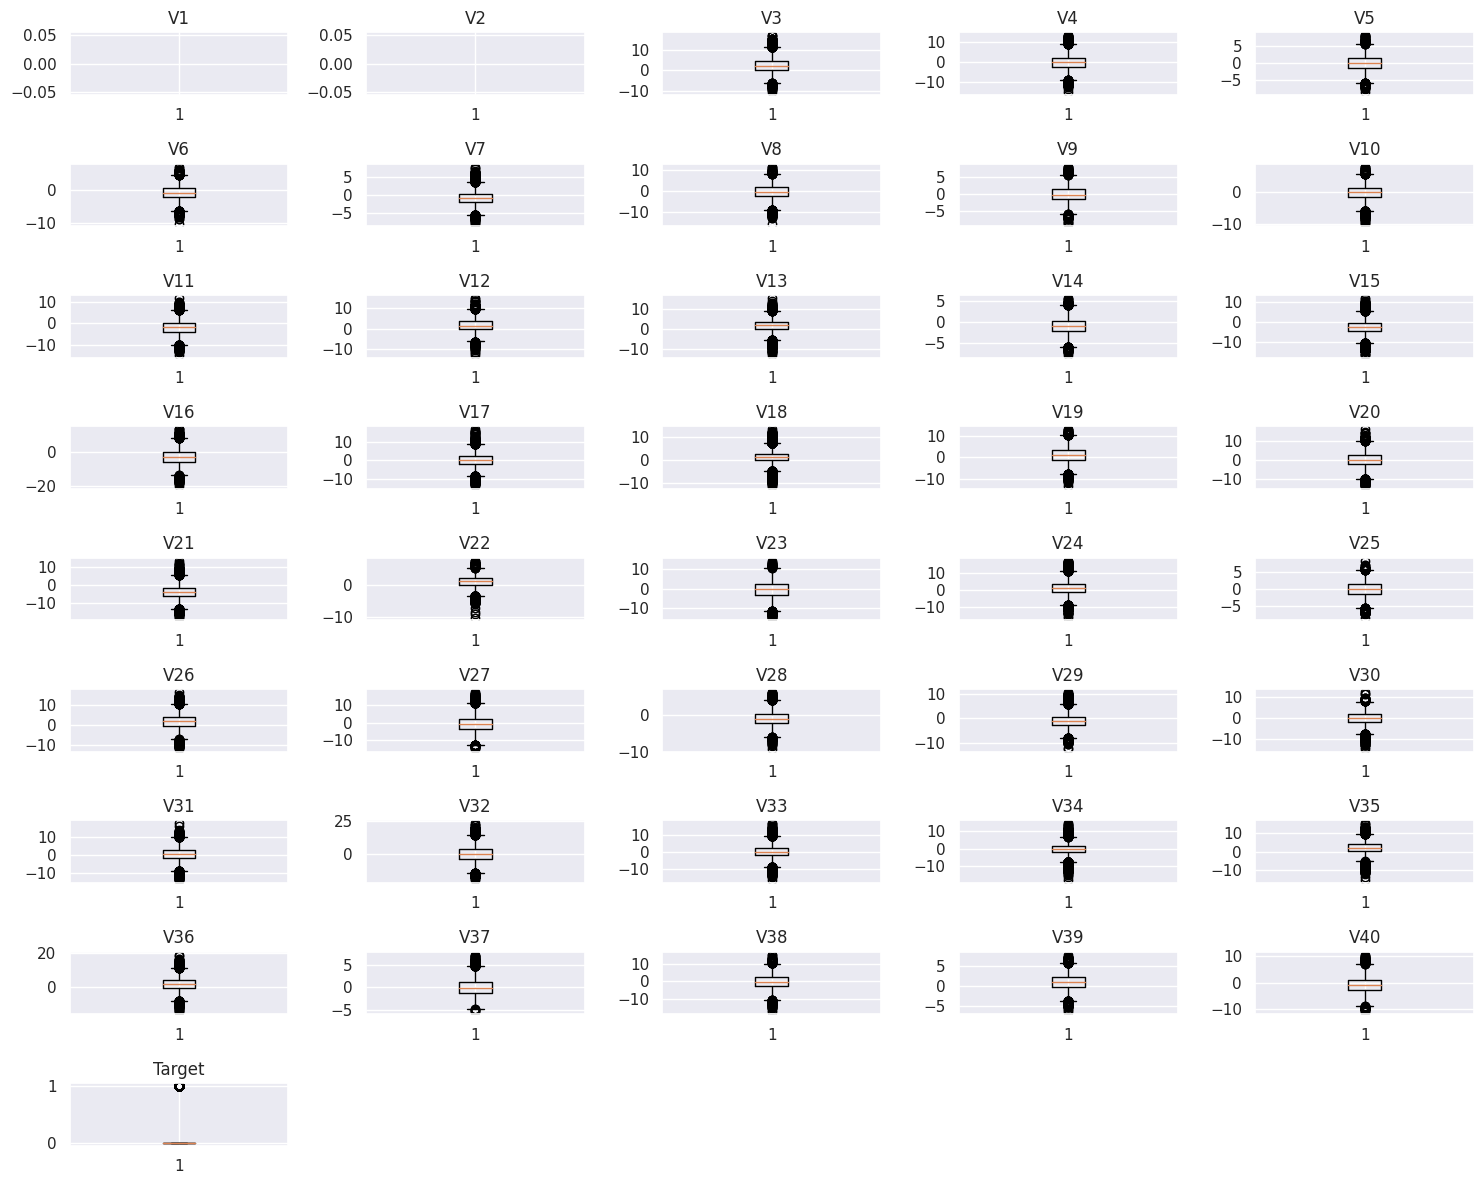

In [ ]:
# outlier detection using boxplot for train data
numeric_columns = data_train.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(15, 12))

for i, variable in enumerate(numeric_columns):
    plt.subplot(9, 5, i + 1)
    plt.boxplot(data_train[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)
plt.show()

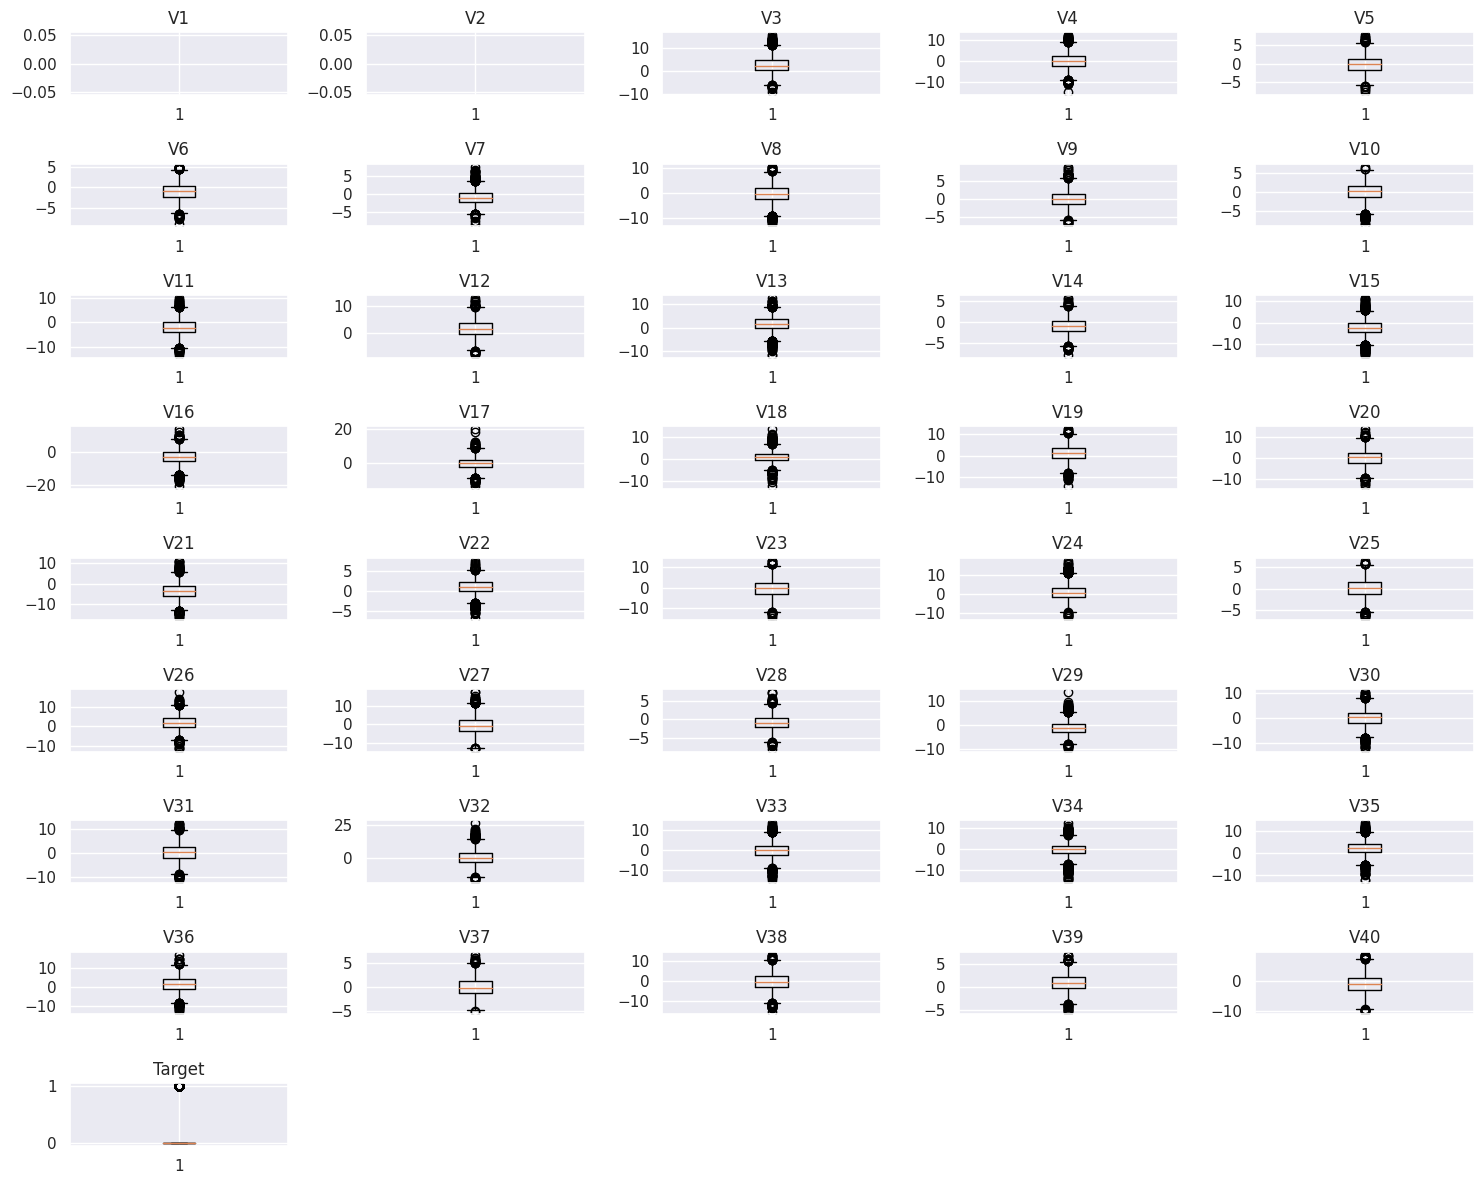

In [ ]:
# outlier detection using boxplot for test data
numeric_columns = data_test.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(15, 12))

for i, variable in enumerate(numeric_columns):
    plt.subplot(9, 5, i + 1)
    plt.boxplot(data_test[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)
plt.show()

## Exploratory Data Analysis

### Univariate analysis

In [ ]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

#### Plotting histograms and boxplots for all the variables

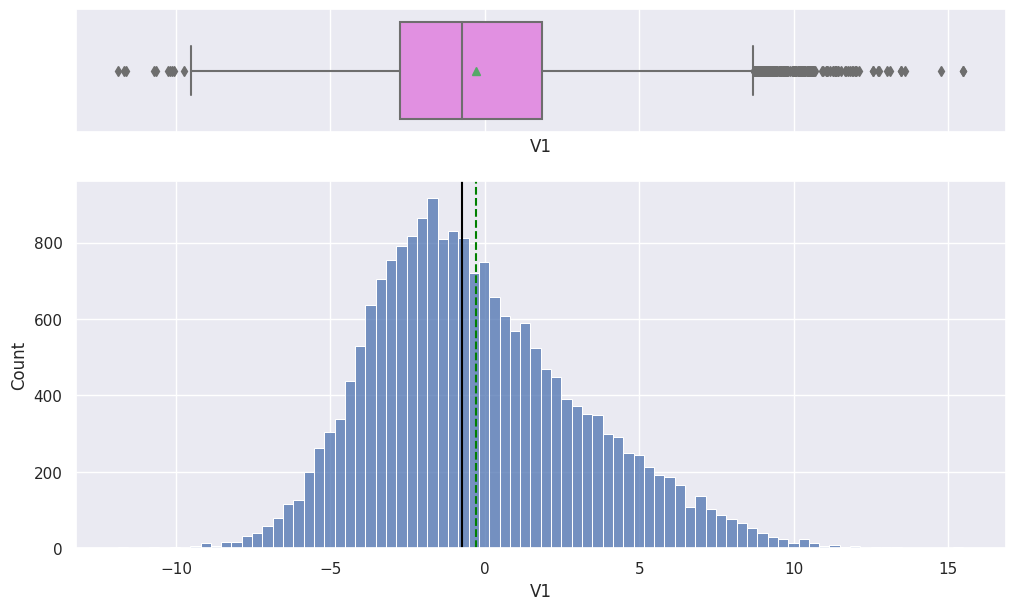

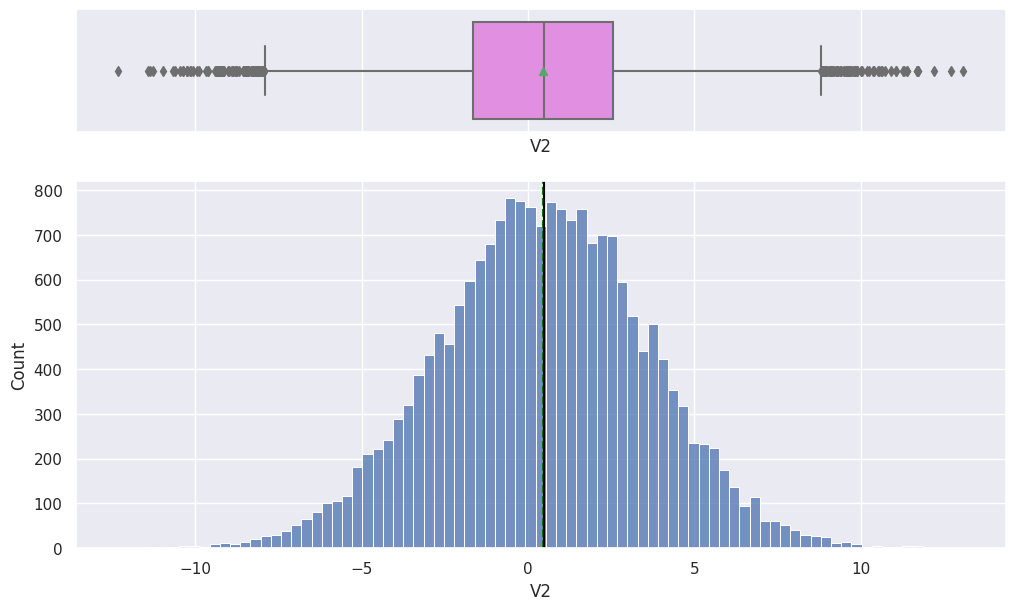

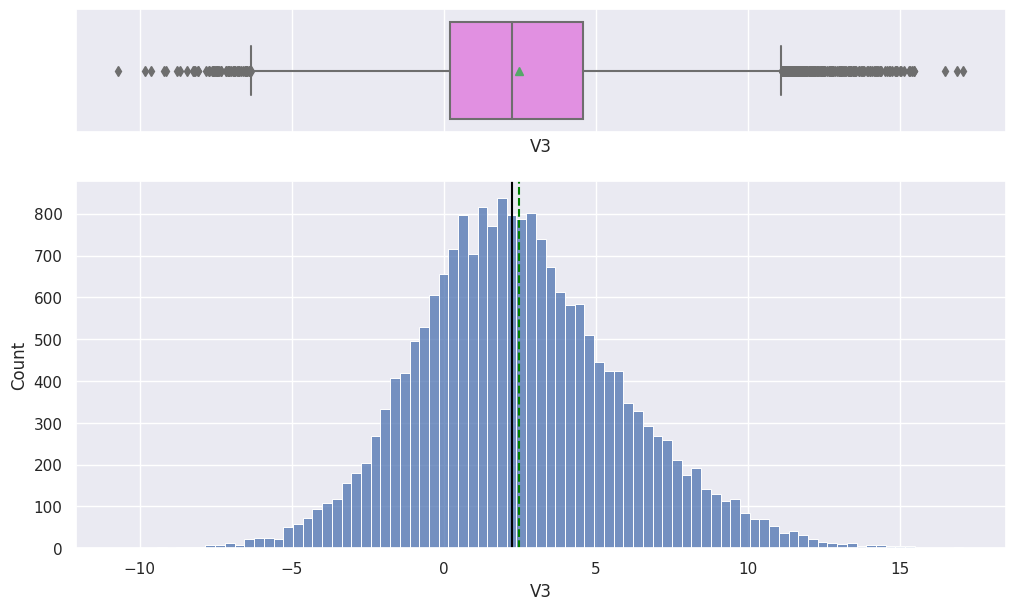

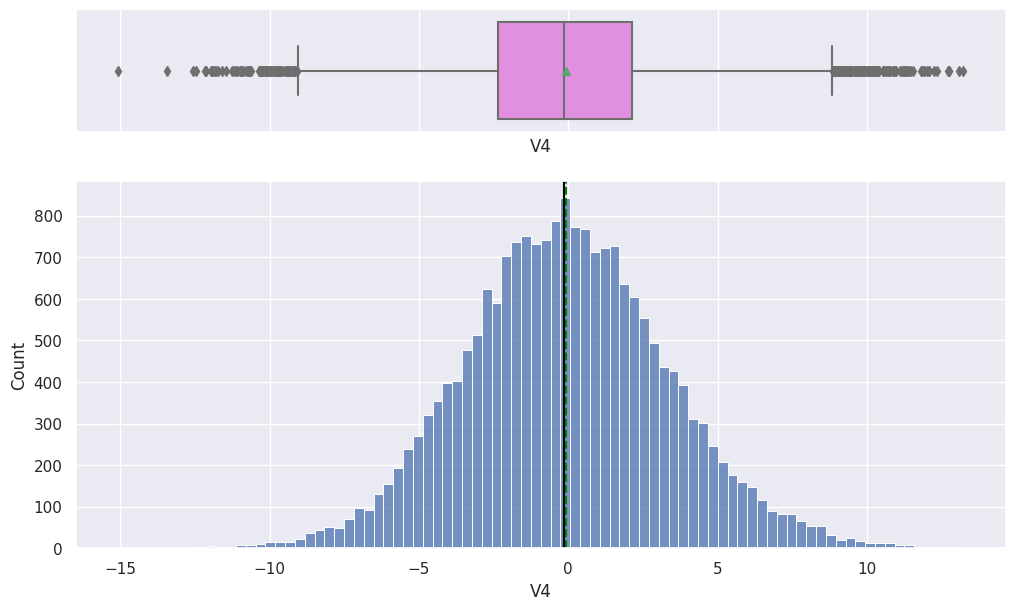

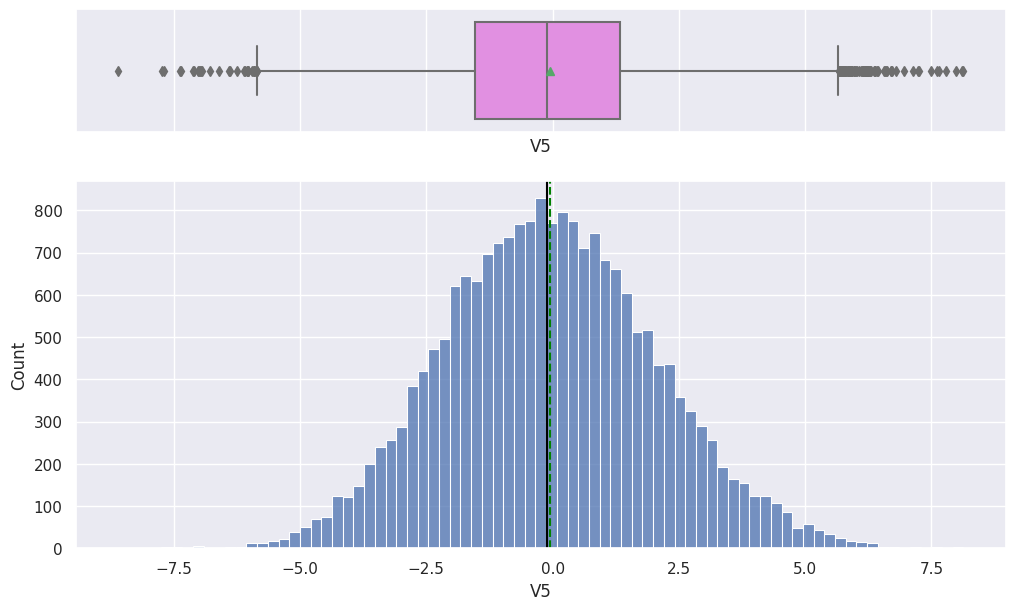

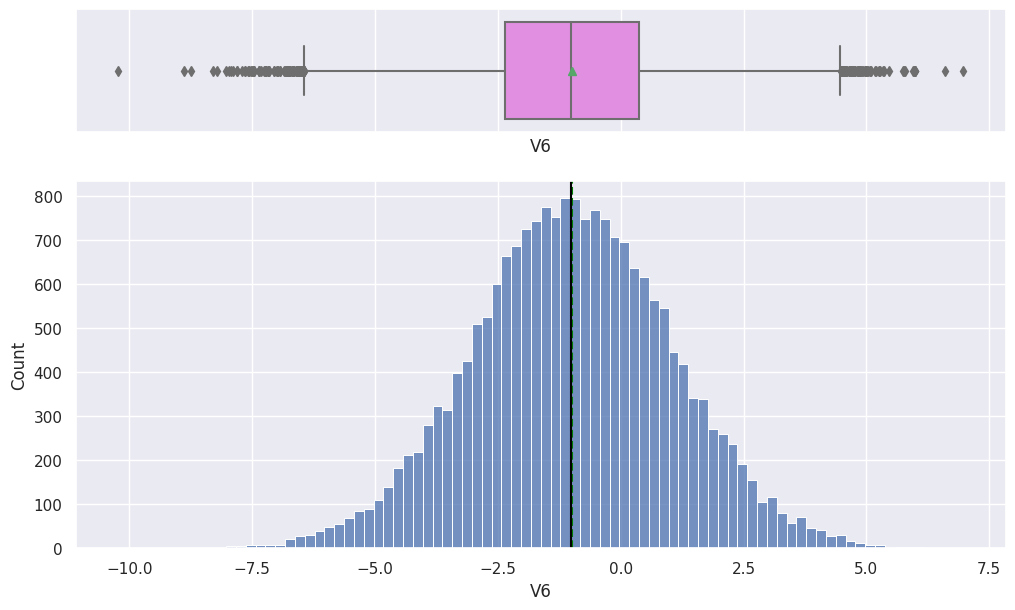

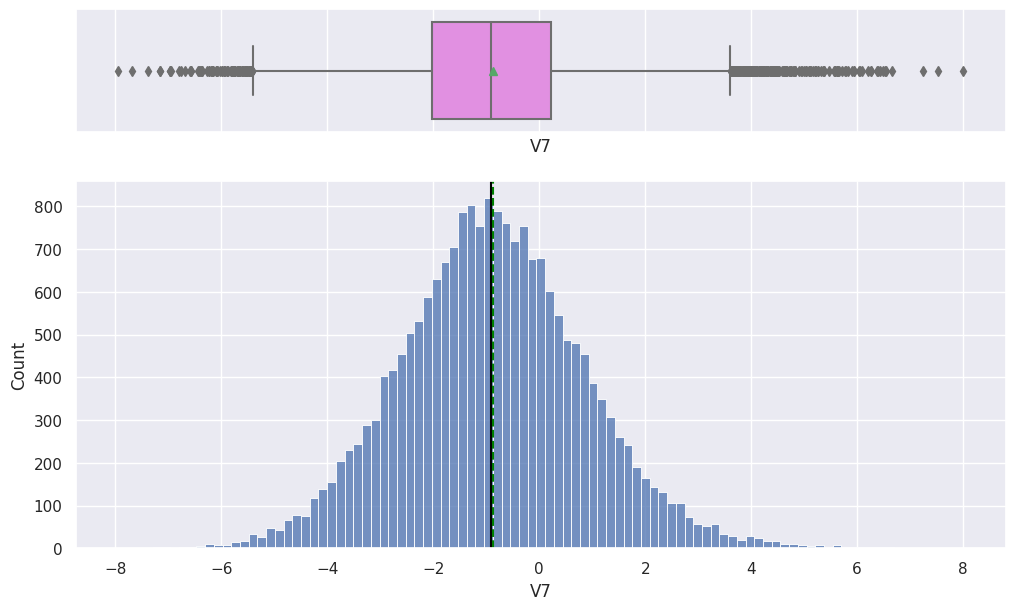

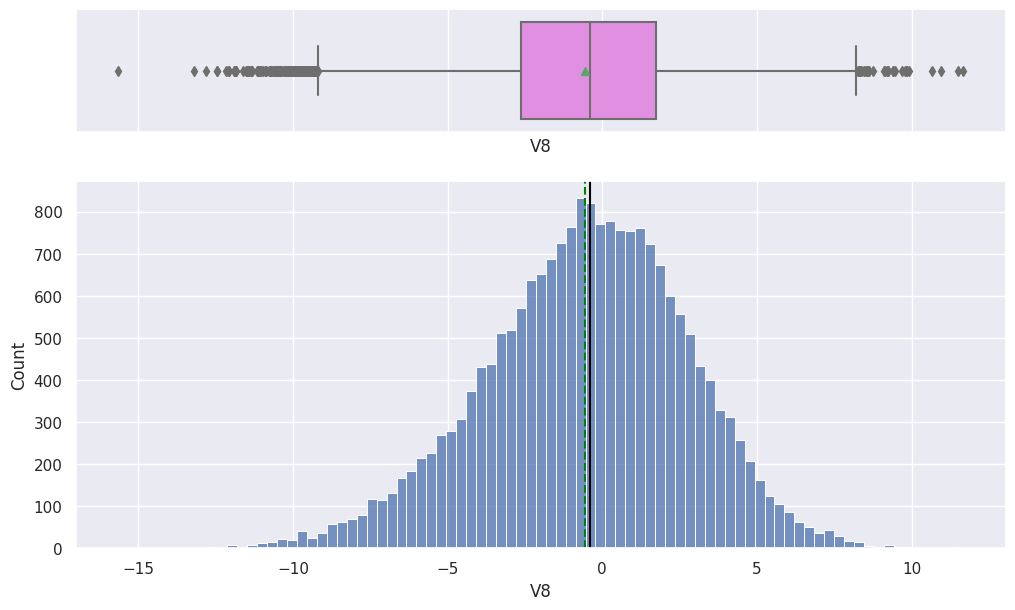

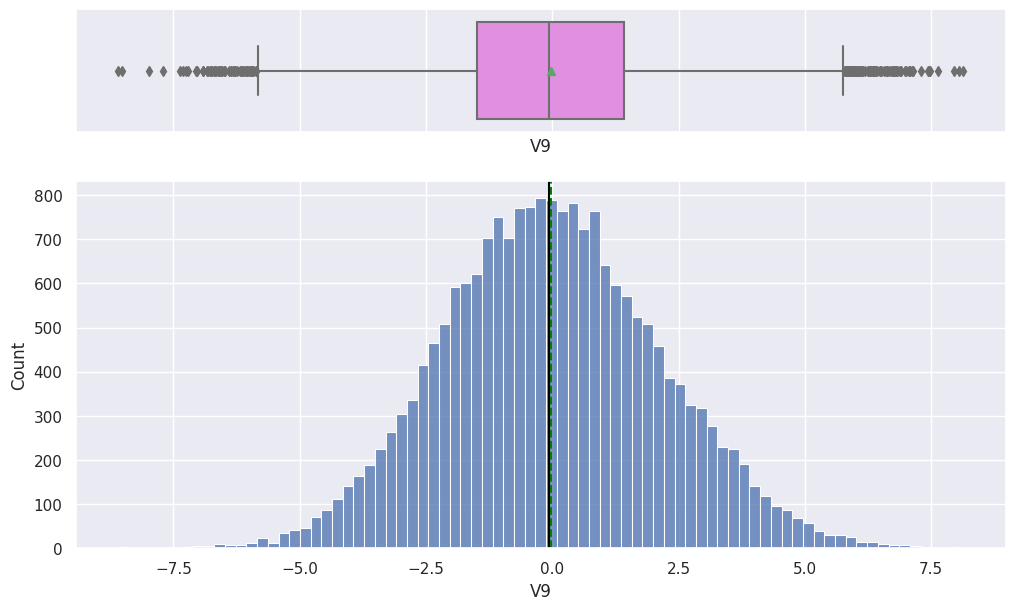

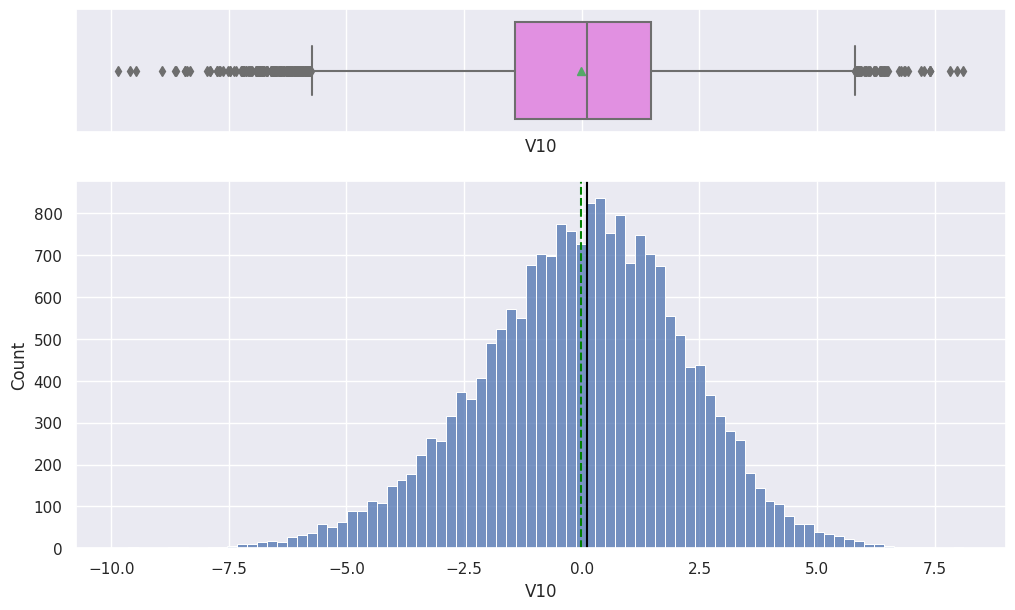

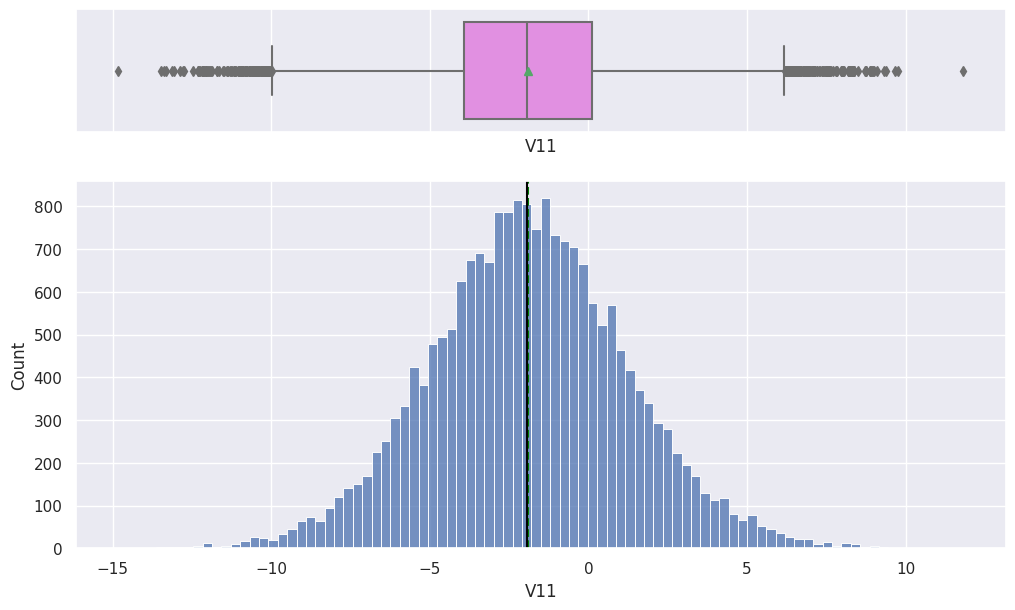

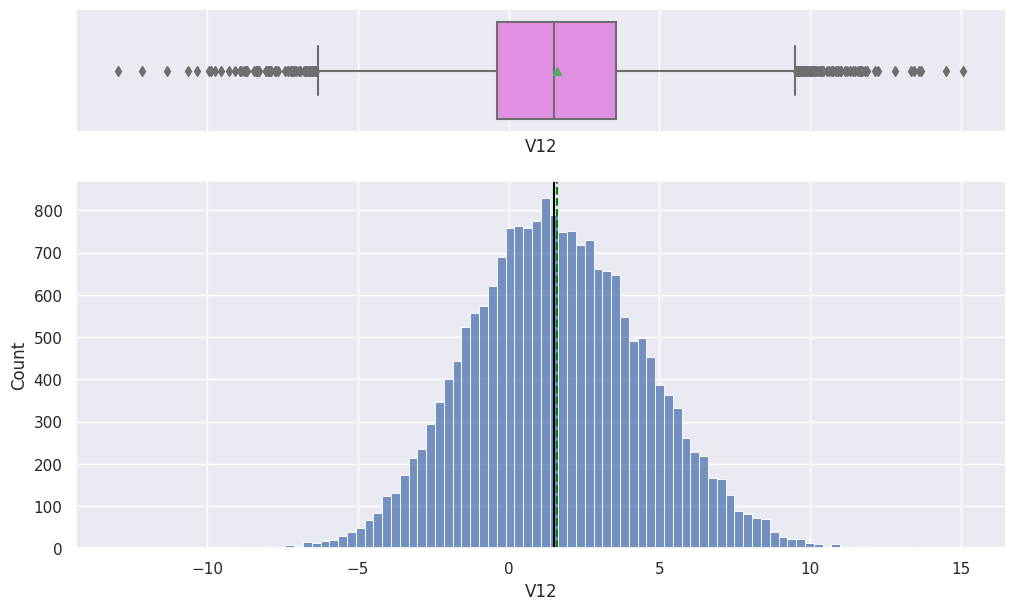

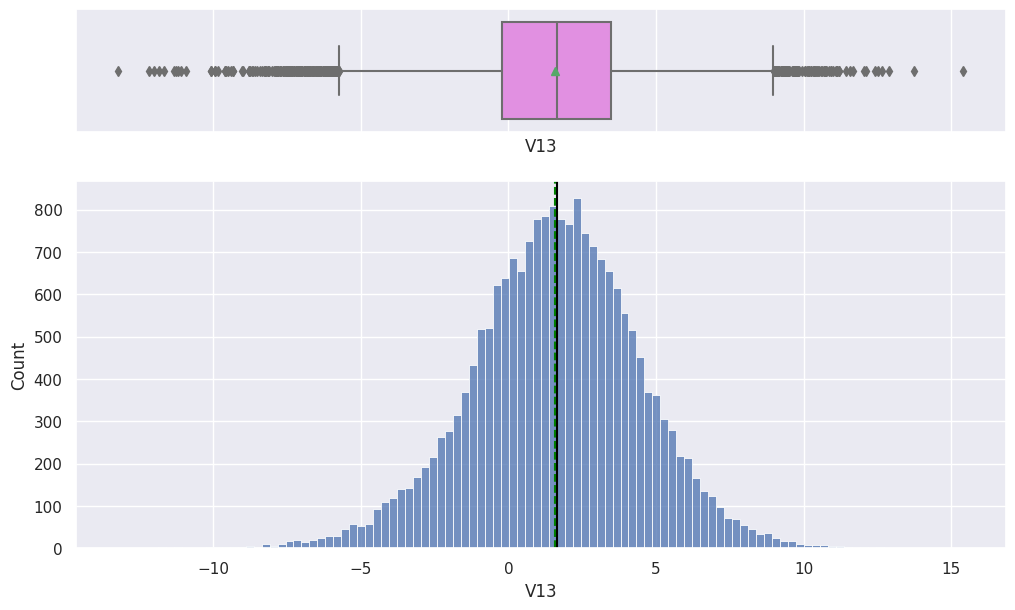

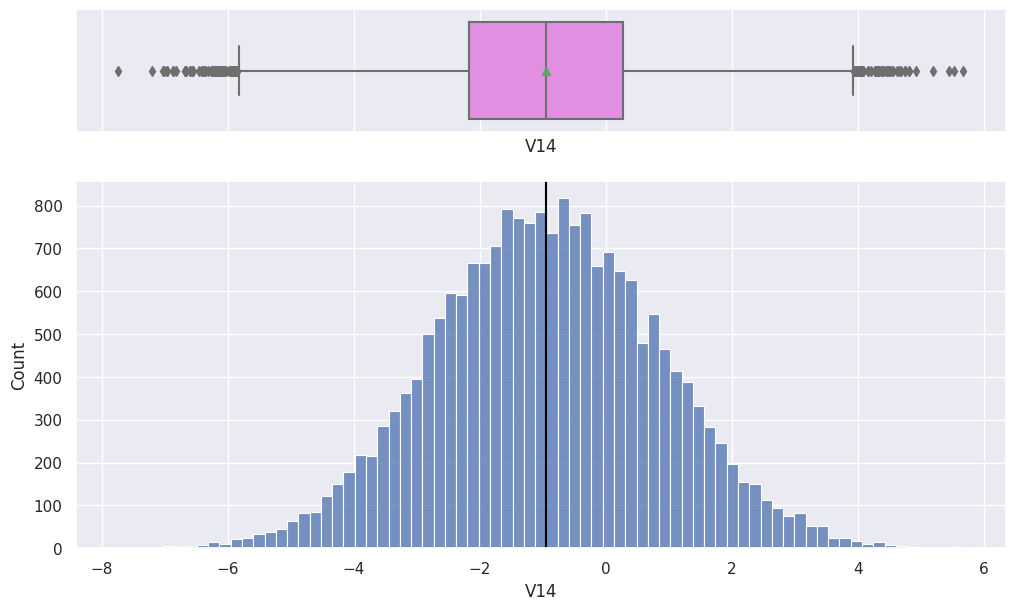

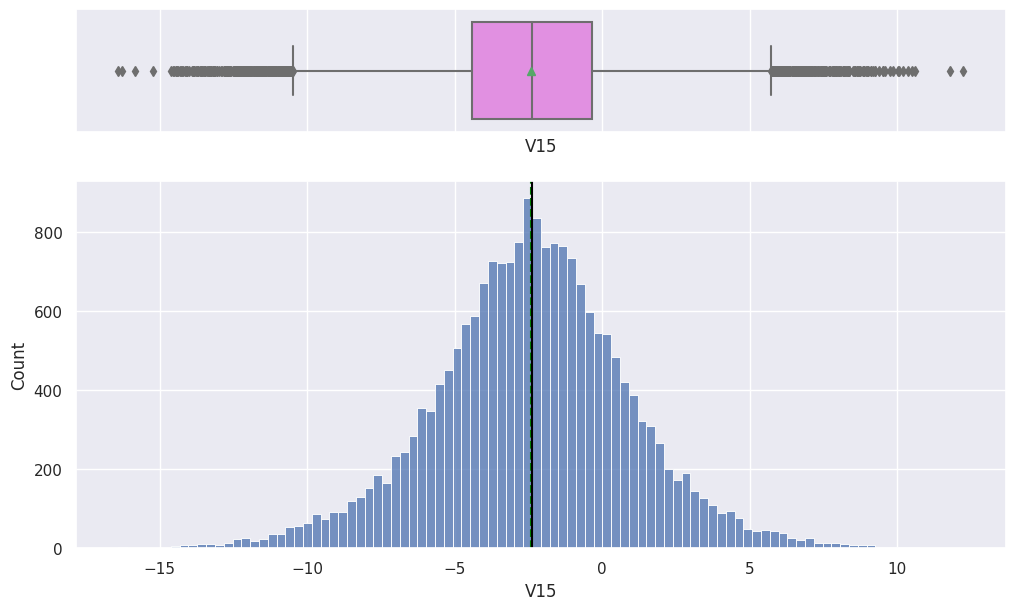

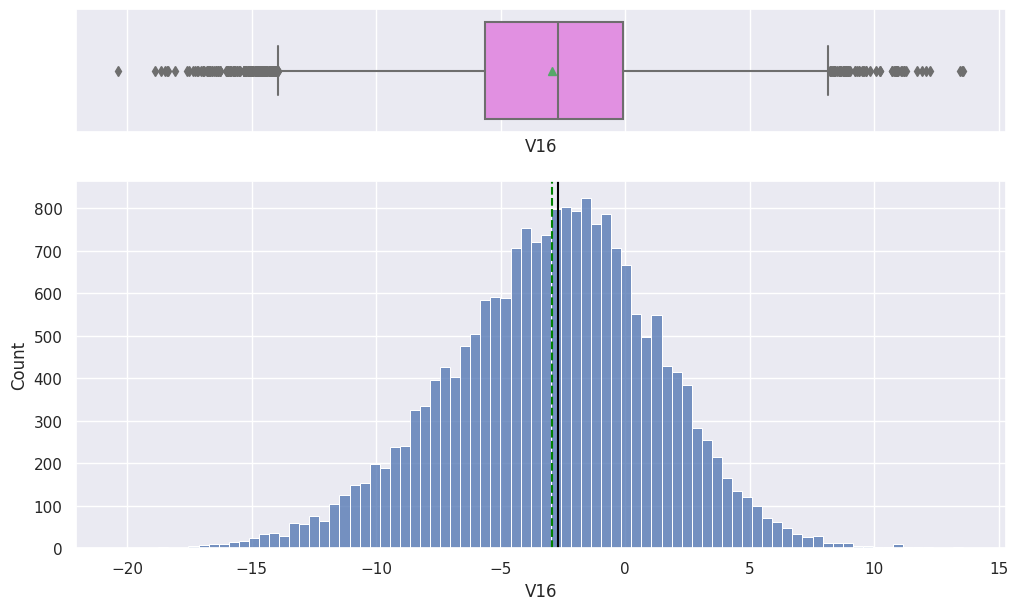

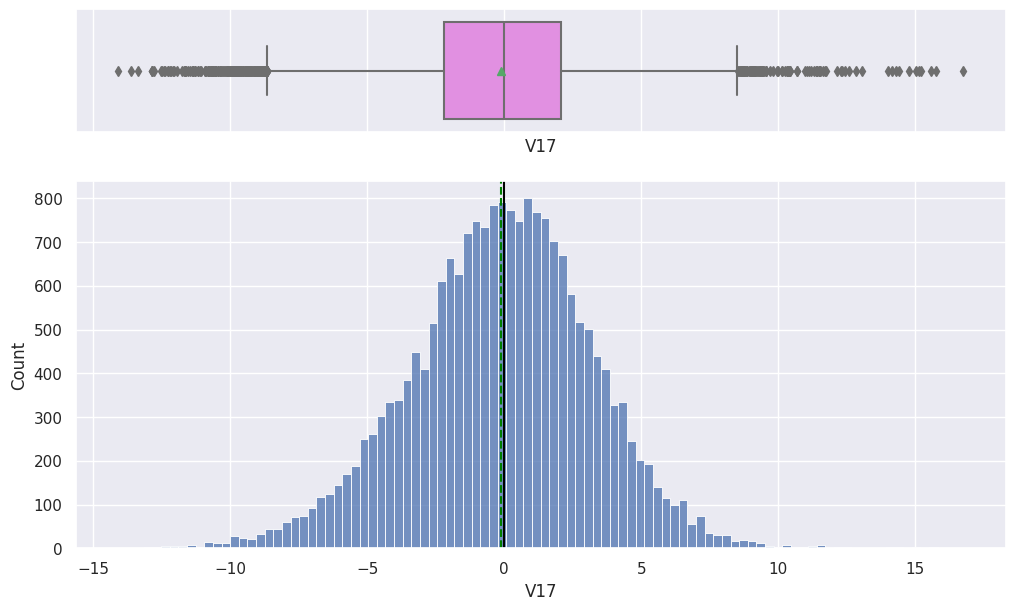

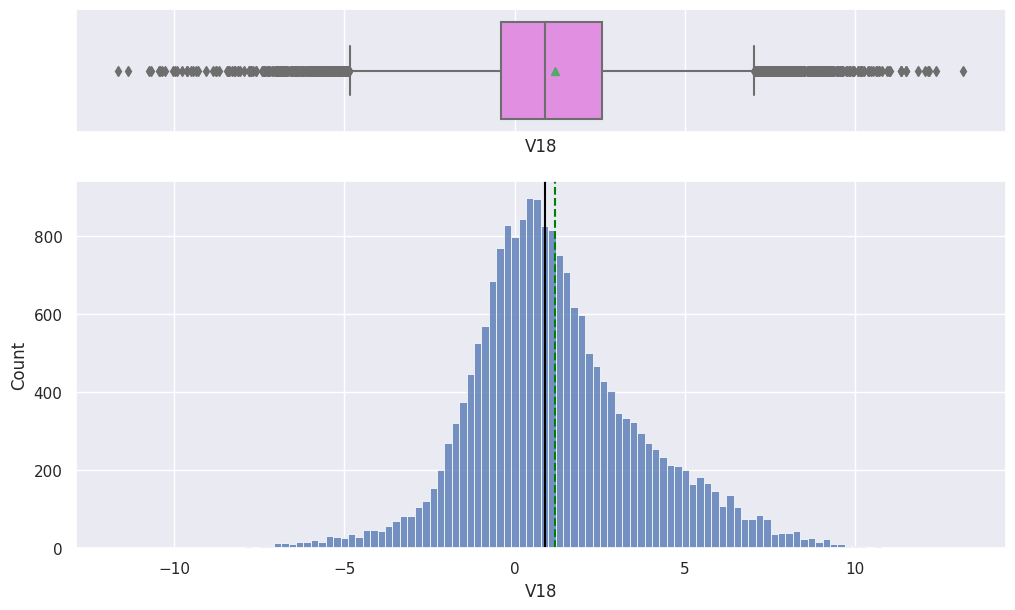

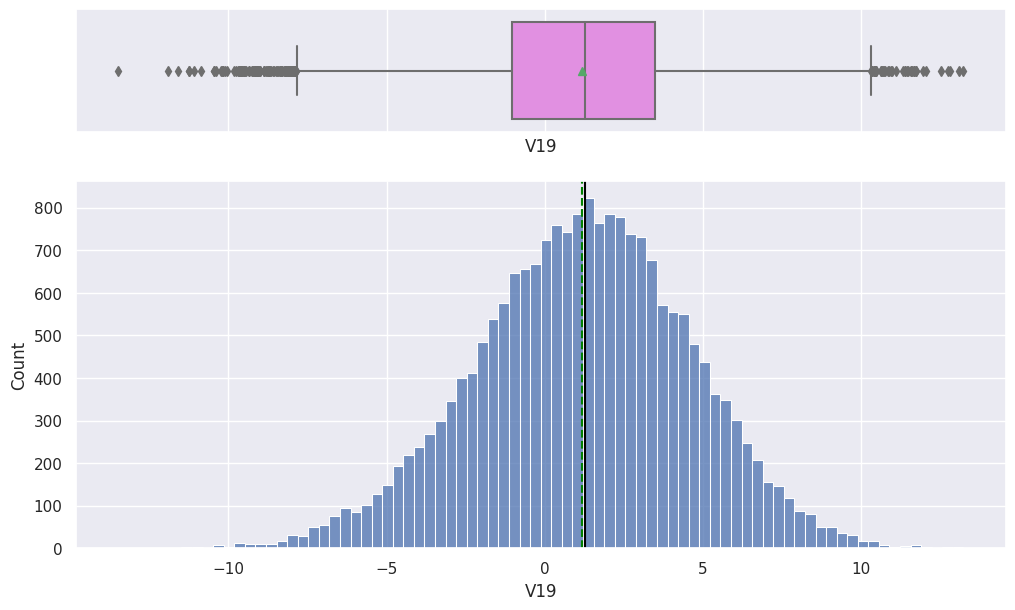

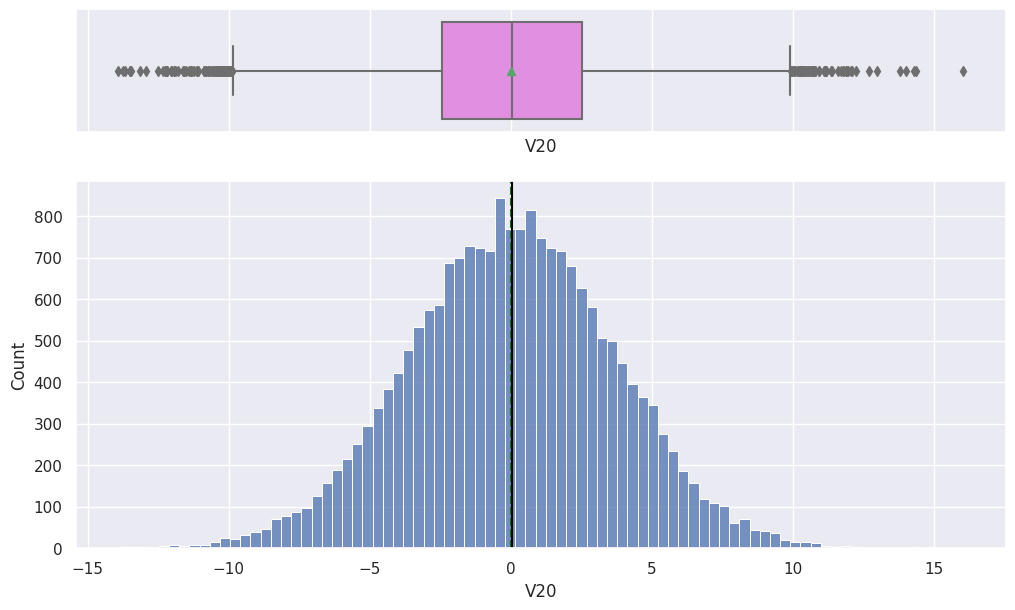

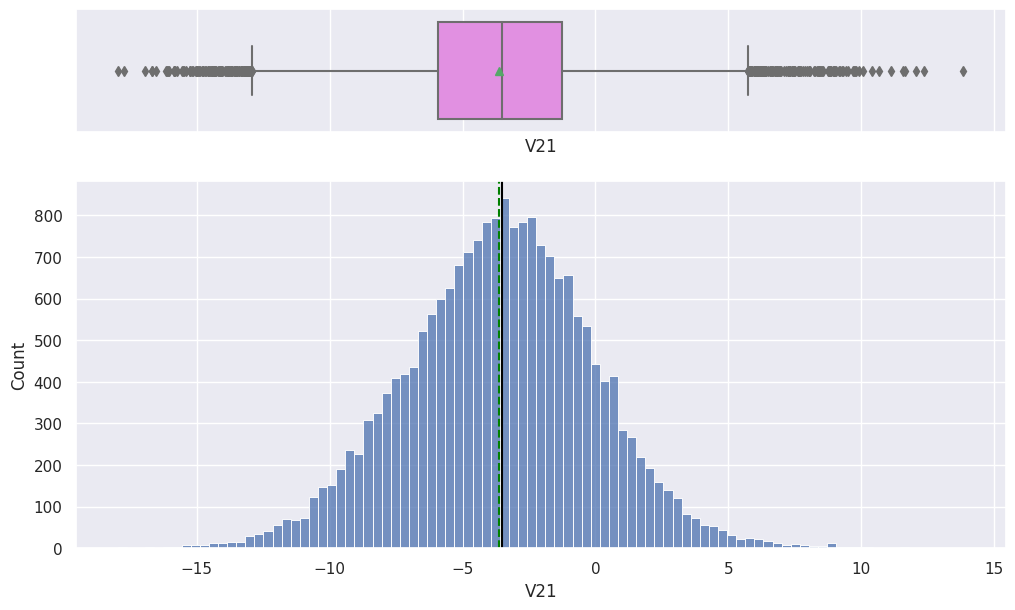

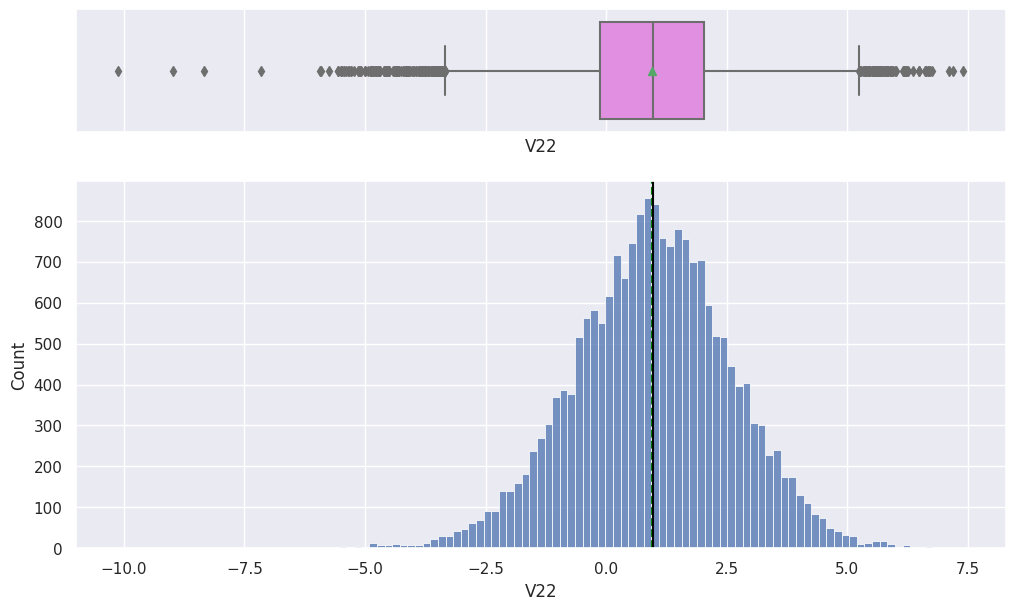

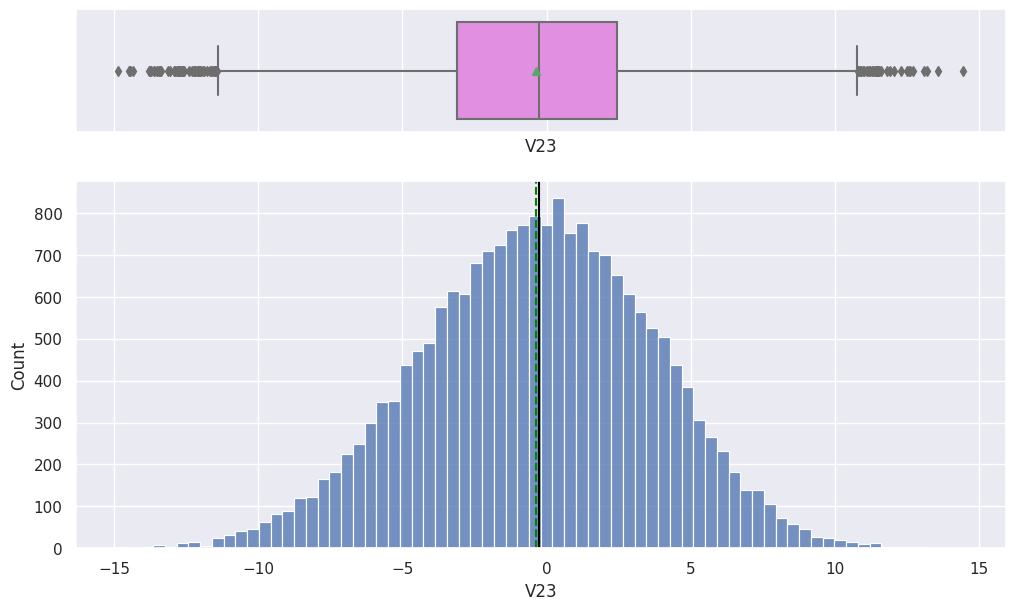

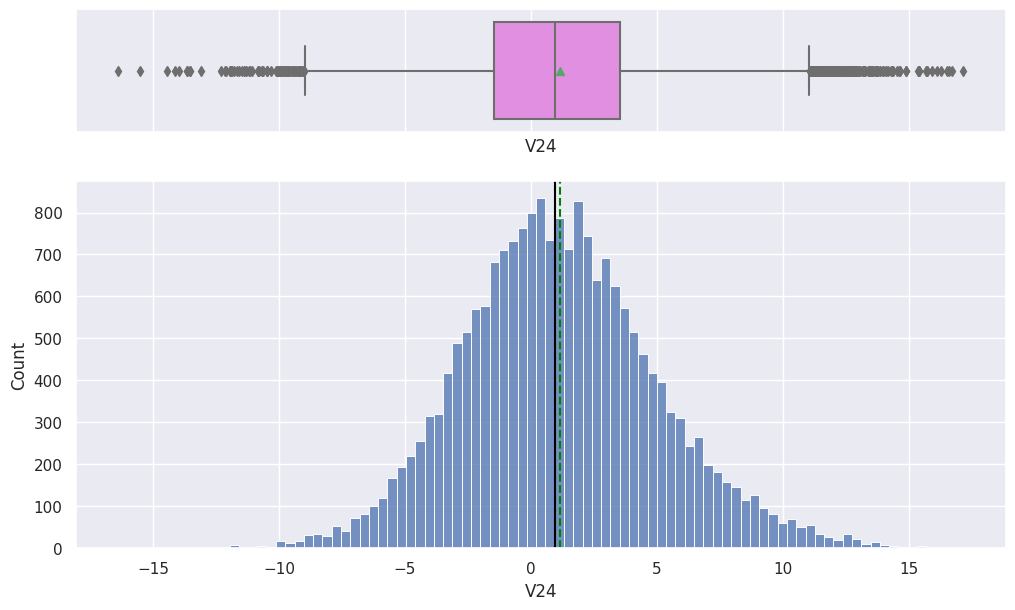

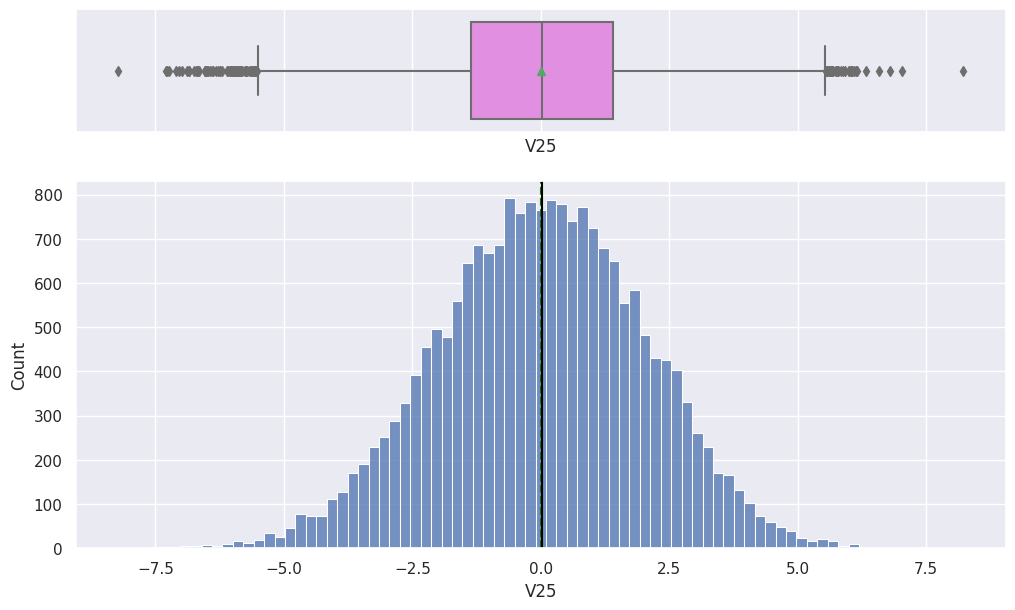

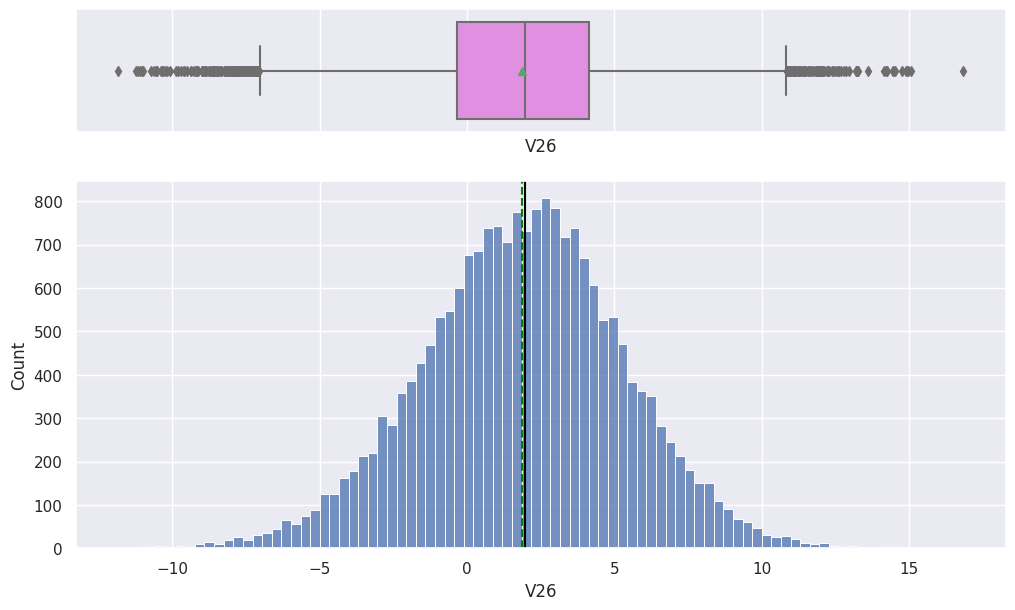

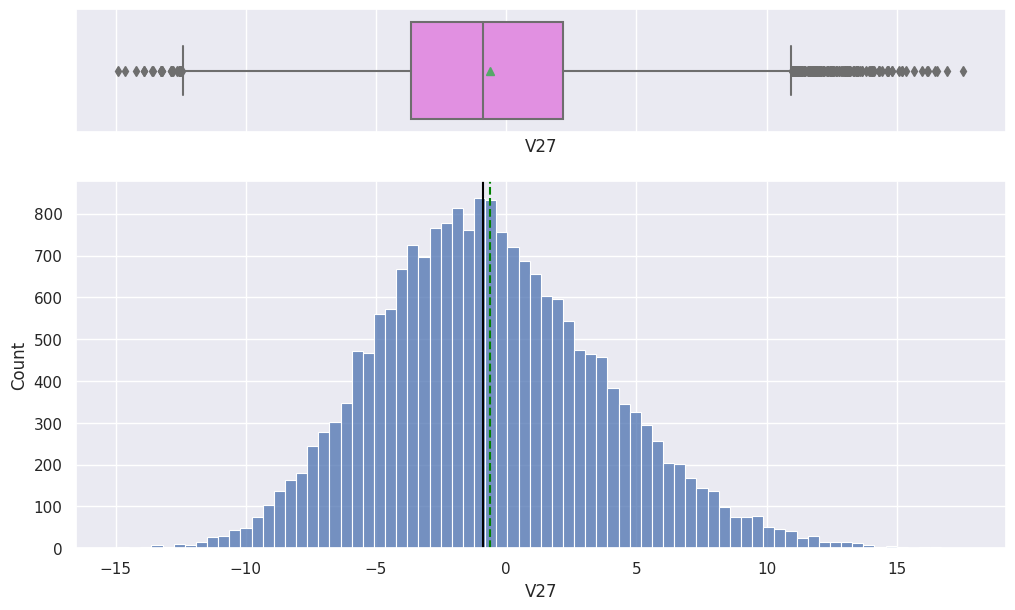

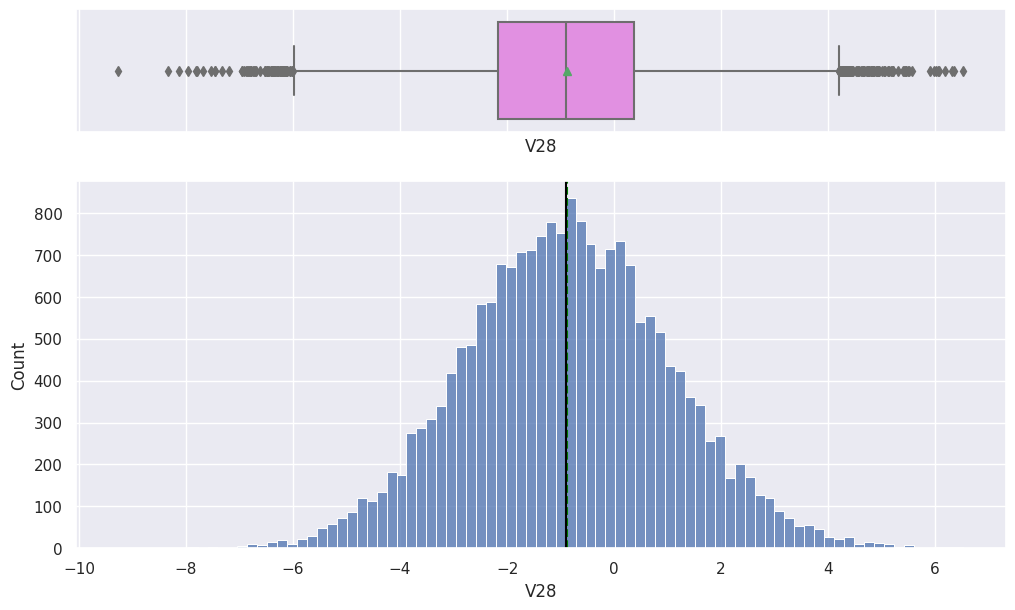

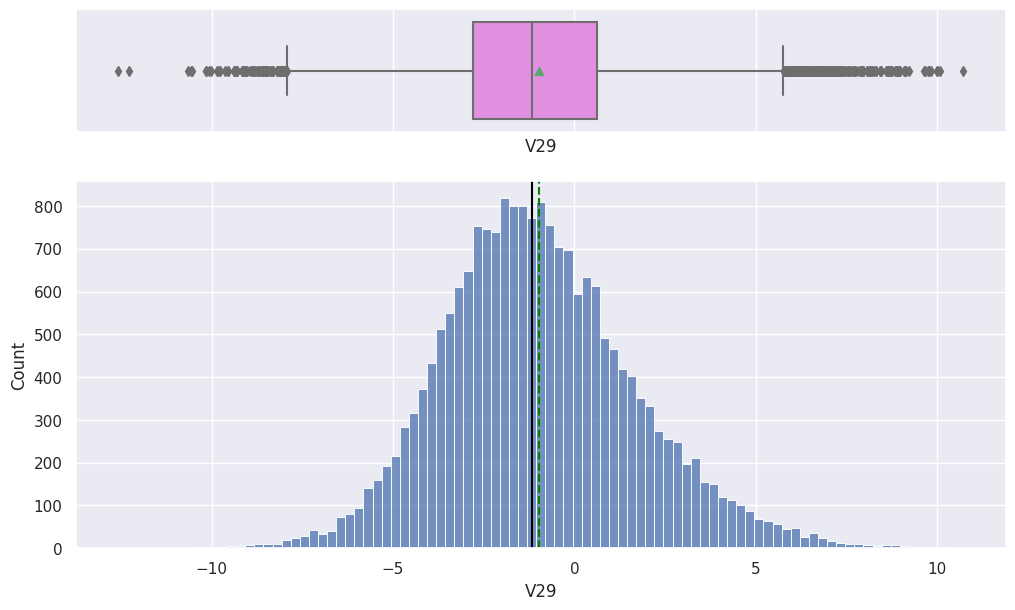

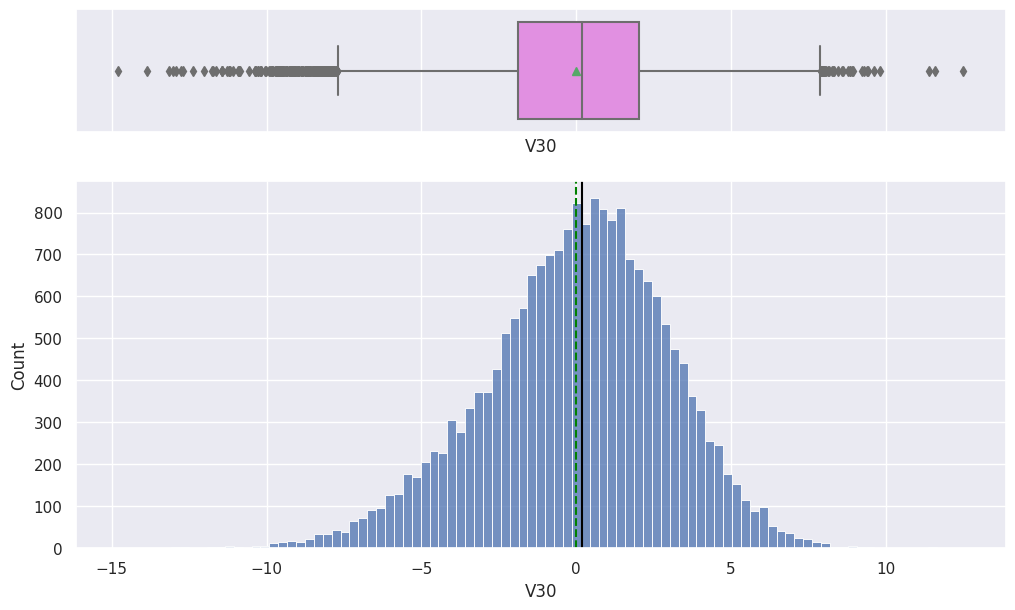

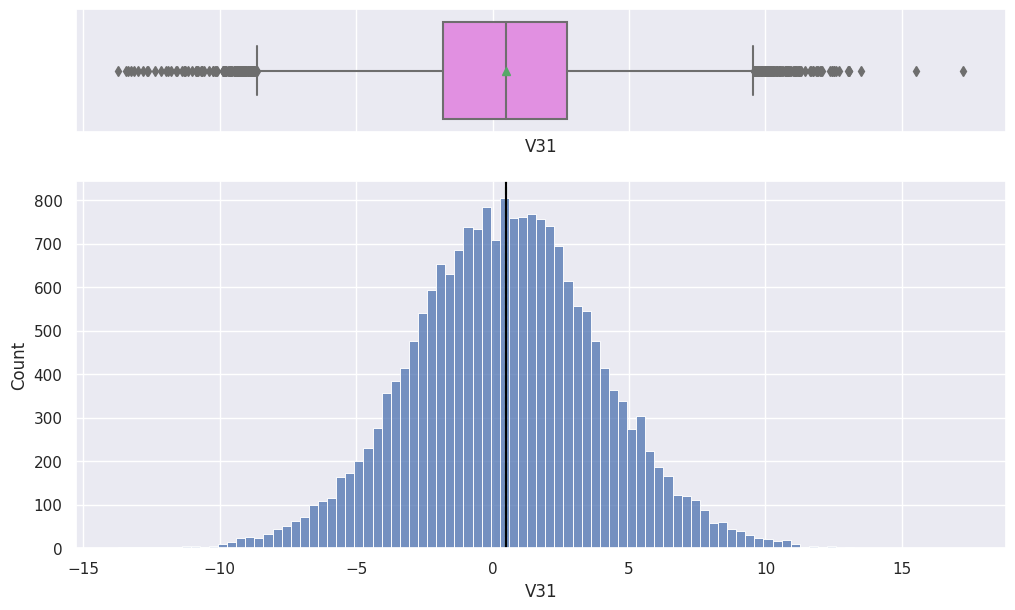

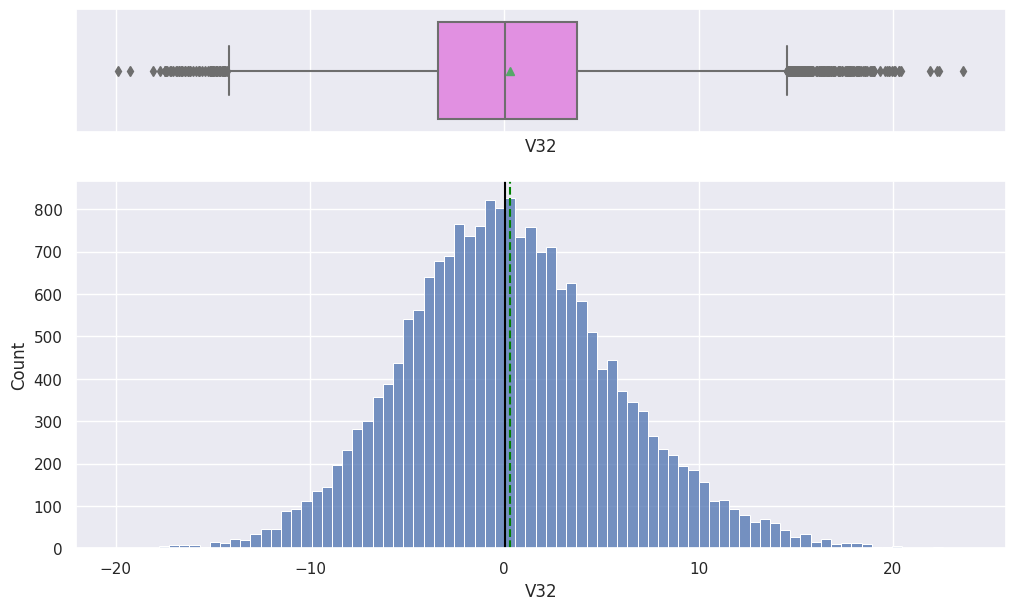

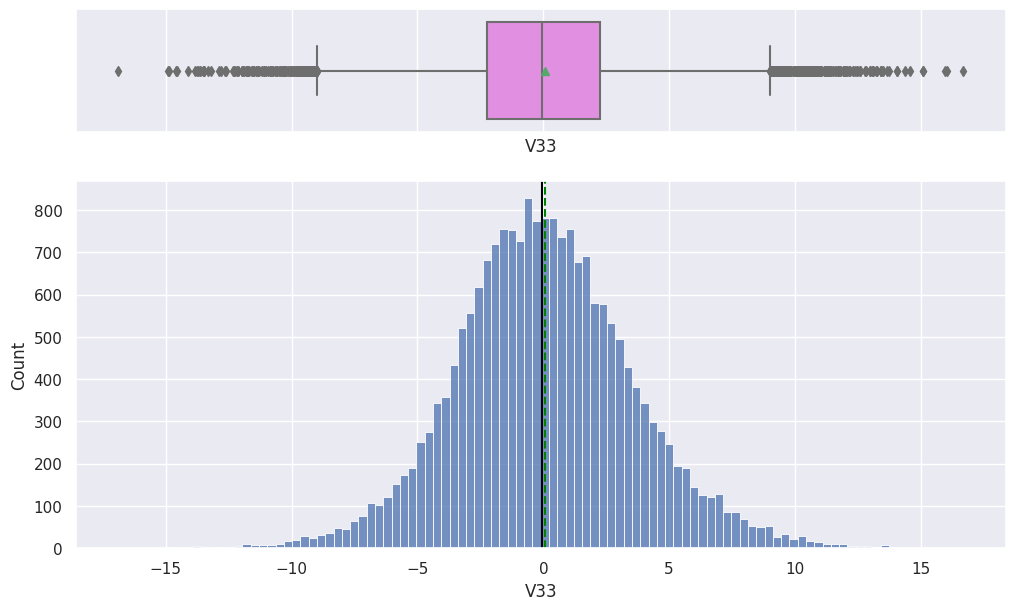

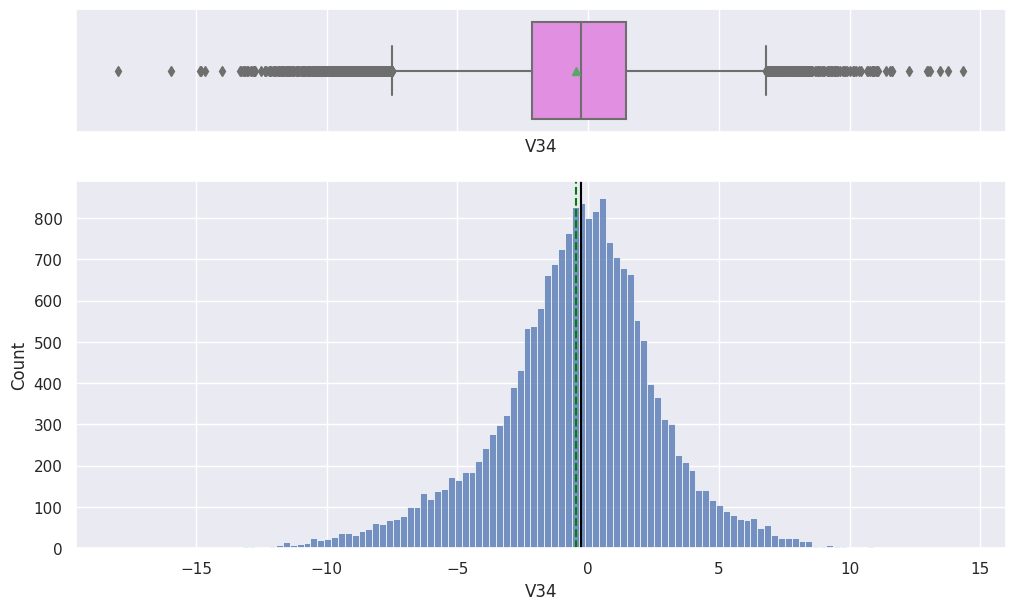

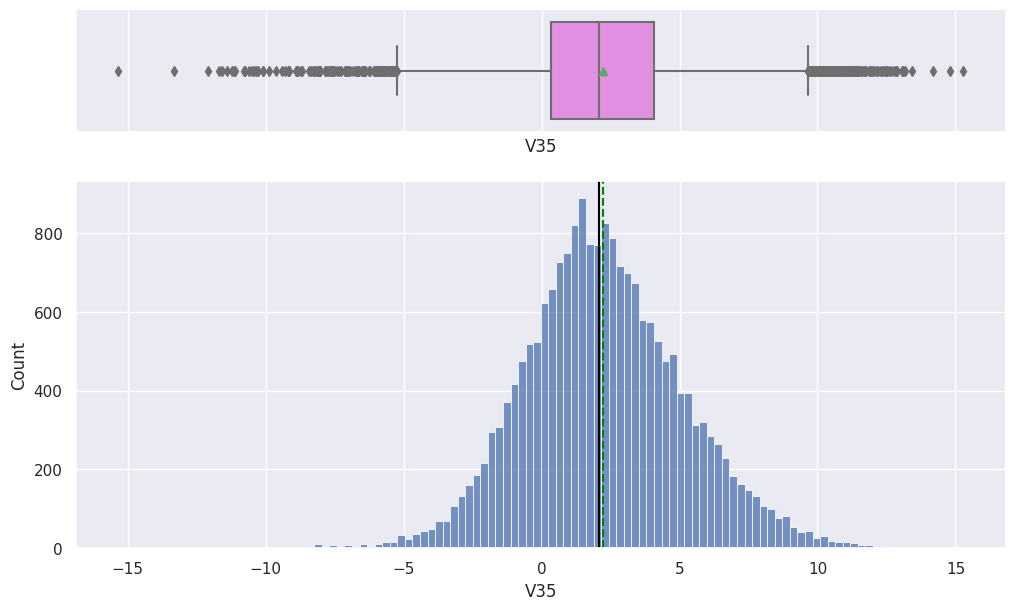

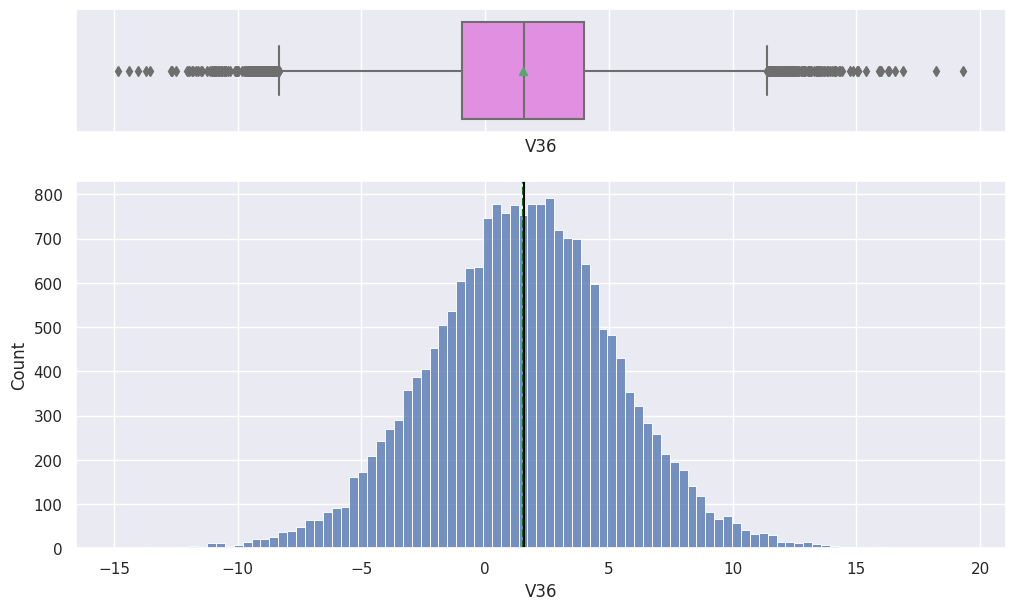

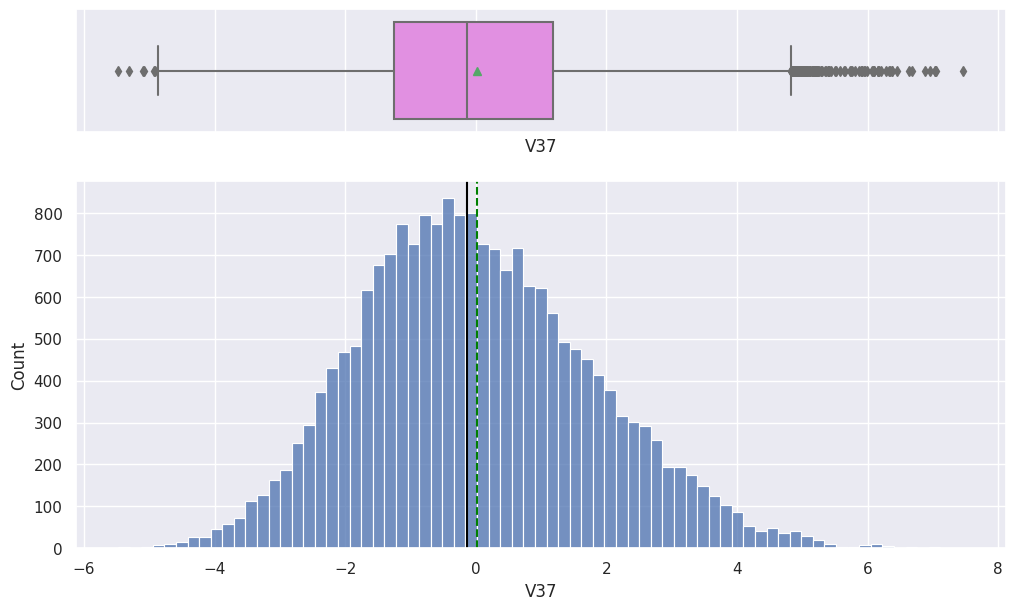

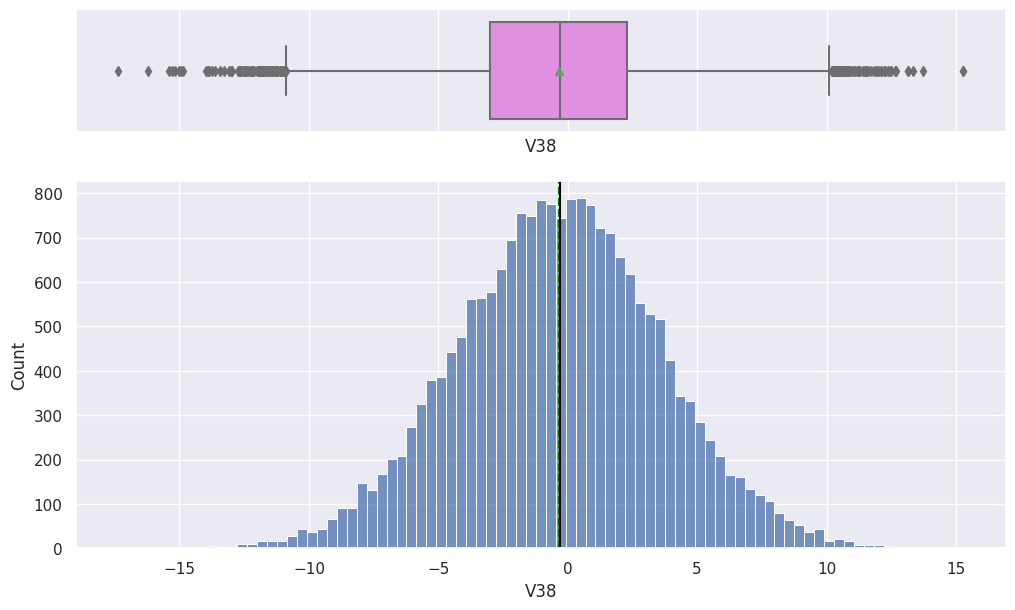

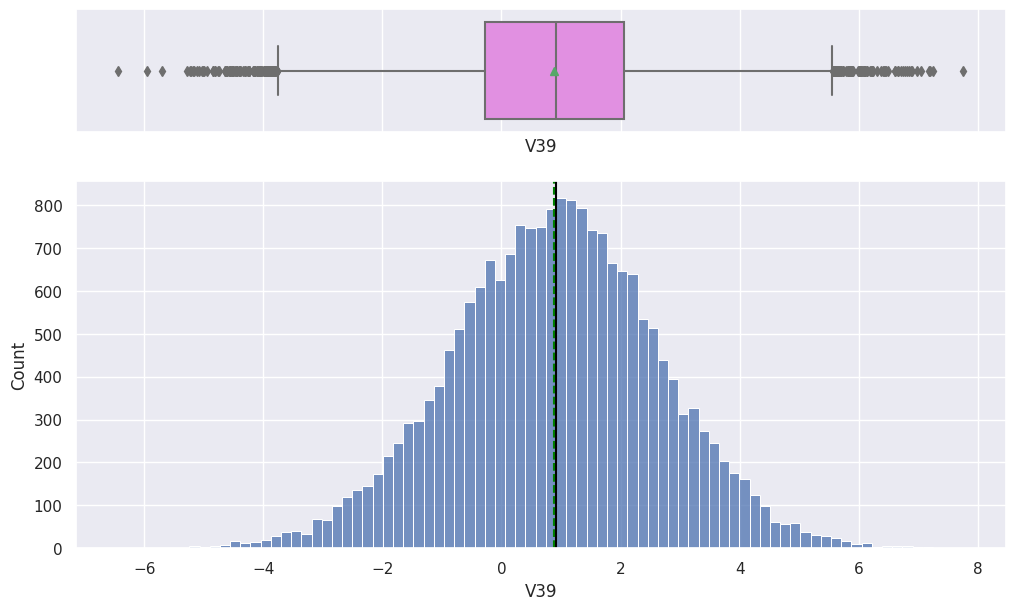

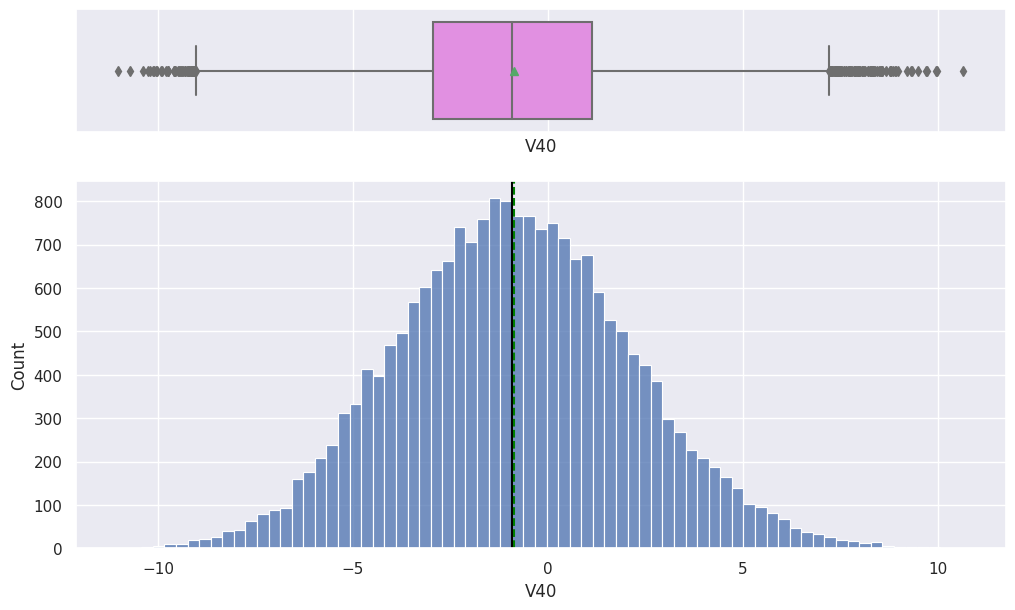

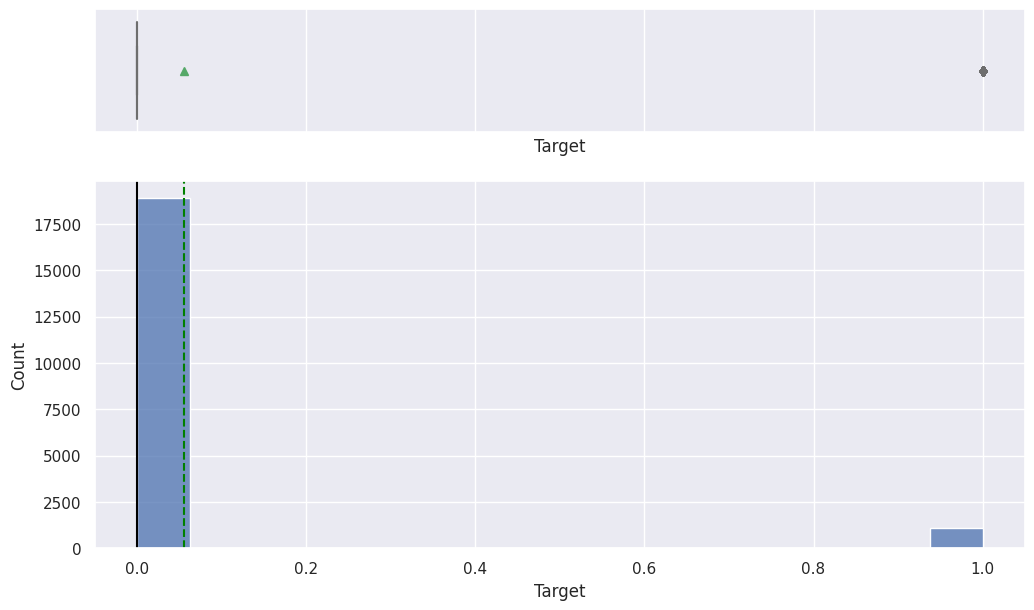

In [ ]:
for feature in data_train.columns:
    histogram_boxplot(data_train, feature, figsize=(12, 7), kde=False, bins=None)

* most variables have a binomial distribution
* Target has only 1's and 0's in its distribution
* V1, V3, V18, and V37 have a slight right-skew distribution
* V8, V10, V16, V30, and V34 have a slight left-skew distribution
* every variable has outliers

### Let's look at the values in target variable

In [ ]:
data_train["Target"].value_counts().describe()

count       2.000
mean    10000.000
std     12572.359
min      1110.000
25%      5555.000
50%     10000.000
75%     14445.000
max     18890.000
Name: Target, dtype: float64

In [ ]:
data_test["Target"].value_counts().describe()

count      2.000
mean    2500.000
std     3136.726
min      282.000
25%     1391.000
50%     2500.000
75%     3609.000
max     4718.000
Name: Target, dtype: float64

## Data Pre-Processing

In [ ]:
# Dividing train data into X and y
X = data_train.drop(["Target"], axis=1)
y = data_train["Target"]

**Since we already have a separate test set, we don't need to divide data into train, valiation and test**


In [ ]:
# Splitting train dataset into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

In [ ]:
#number of columns and rows in X_train
X_train.shape

(15000, 40)

In [ ]:
#number of columns and rows in X-val
X_val.shape

(5000, 40)

In [ ]:
# Dividing test data into X_test and y_test
X_test = data_test.drop(["Target"], axis=1)
y_test = data_test["Target"]

In [ ]:
# Checking the number of rows and columns in the X_test data
X_test.shape

(5000, 40)

## Missing value imputation




In [ ]:
# creating an instace of the imputer to be used
imputer = SimpleImputer(strategy="median")

In [ ]:
# Fit and transform the train data
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Transform the validation data
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_train.columns)

# Transform the test data
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_train.columns)

In [ ]:
# Checking that no column has missing values in train or test sets
print(X_train.isna().sum())
print("-" * 30)
print(X_val.isna().sum())
print("-" * 30)
print(X_test.isna().sum())

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model.
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1
        },
        index=[0],
    )

    return df_perf

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [ ]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

### Model Building on original data

In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Logistic regression: 0.4927566553639709
Bagging: 0.7210807301060529
Random forest: 0.7235192266070268
GBM: 0.7066661857008874
Adaboost: 0.6309140754635308
Xgboost: 0.7956208065796118
dtree: 0.6982829521679532

Validation Performance:

Logistic regression: 0.48201438848920863
Bagging: 0.7302158273381295
Random forest: 0.7266187050359713
GBM: 0.7230215827338129
Adaboost: 0.6762589928057554
Xgboost: 0.8201438848920863
dtree: 0.7050359712230215


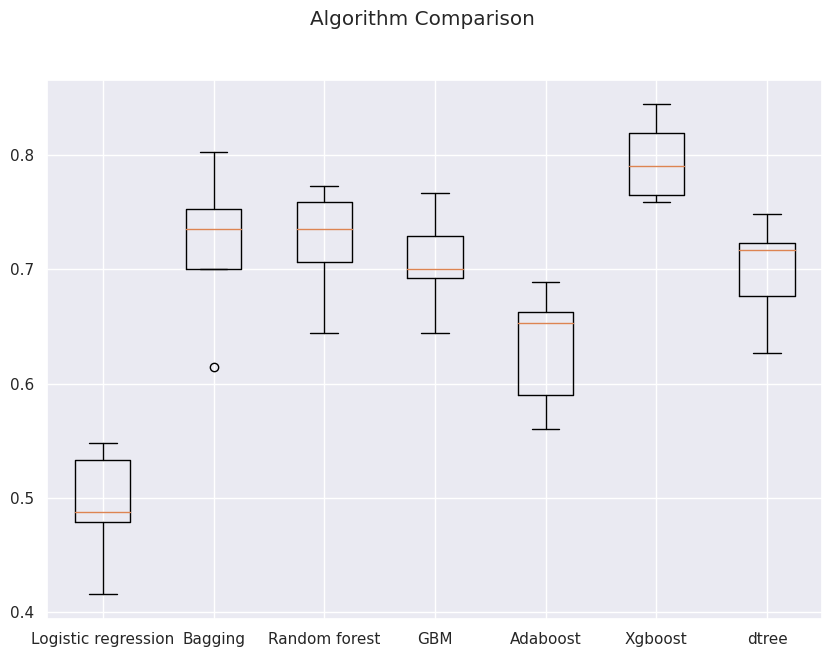

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

XGBoost has the highest level of Recall using original data, followed by Bagging and then Random Forest

### Model Building with oversampled data

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After OverSampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))


print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before OverSampling, counts of label '1': 832
Before OverSampling, counts of label '0': 14168 

After OverSampling, counts of label '1': 14168
After OverSampling, counts of label '0': 14168 

After OverSampling, the shape of train_X: (28336, 40)
After OverSampling, the shape of train_y: (28336,) 



In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models

# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_test, y=y_test, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_test,y_test)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Logistic regression: 0.4431704260651629
Bagging: 0.5958020050125313
Random forest: 0.5883458646616541
GBM: 0.6096491228070174
Adaboost: 0.5885338345864662
Xgboost: 0.705639097744361
dtree: 0.6380952380952382

Validation Performance:

Logistic regression: 0.45323741007194246
Bagging: 0.6258992805755396
Random forest: 0.6618705035971223
GBM: 0.6726618705035972
Adaboost: 0.6223021582733813
Xgboost: 0.7697841726618705
dtree: 0.6402877697841727


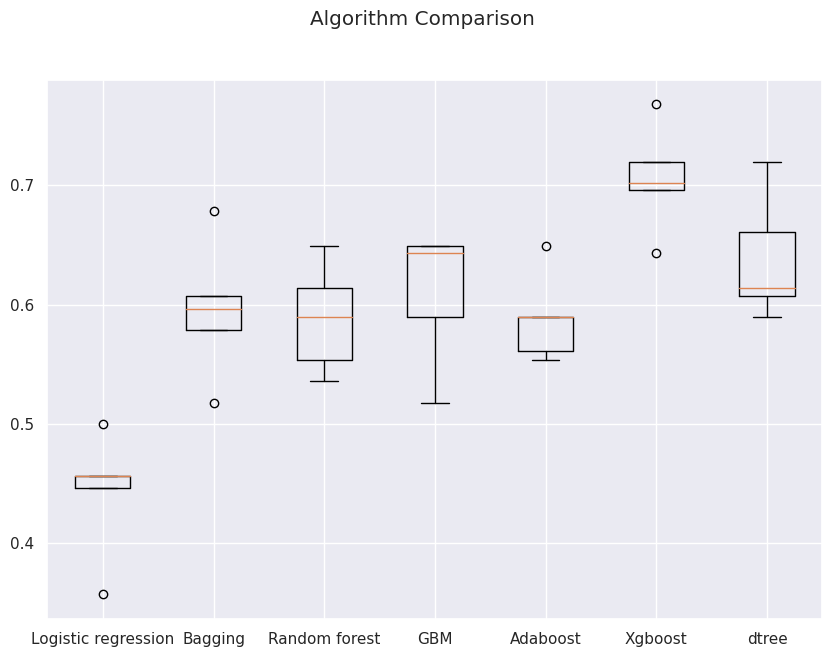

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

XGBoost has the highest level of Recall using oversampled data, followed by decsion tree and then bagging

### Model Building with undersampled data

In [ ]:
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)


print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))


print("After UnderSampling, counts of label '1': {}".format(sum(y_train_un == 1)))
print("After UnderSampling, counts of label '0': {} \n".format(sum(y_train_un == 0)))


print("After UnderSampling, the shape of train_X: {}".format(X_train_un.shape))
print("After UnderSampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before UnderSampling, counts of label '1': 832
Before UnderSampling, counts of label '0': 14168 

After UnderSampling, counts of label '1': 832
After UnderSampling, counts of label '0': 832 

After UnderSampling, the shape of train_X: (1664, 40)
After UnderSampling, the shape of train_y: (1664,) 



In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train,y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Logistic regression: 0.4927566553639709
Bagging: 0.7210807301060529
Random forest: 0.7235192266070268
GBM: 0.7066661857008874
Adaboost: 0.6309140754635308


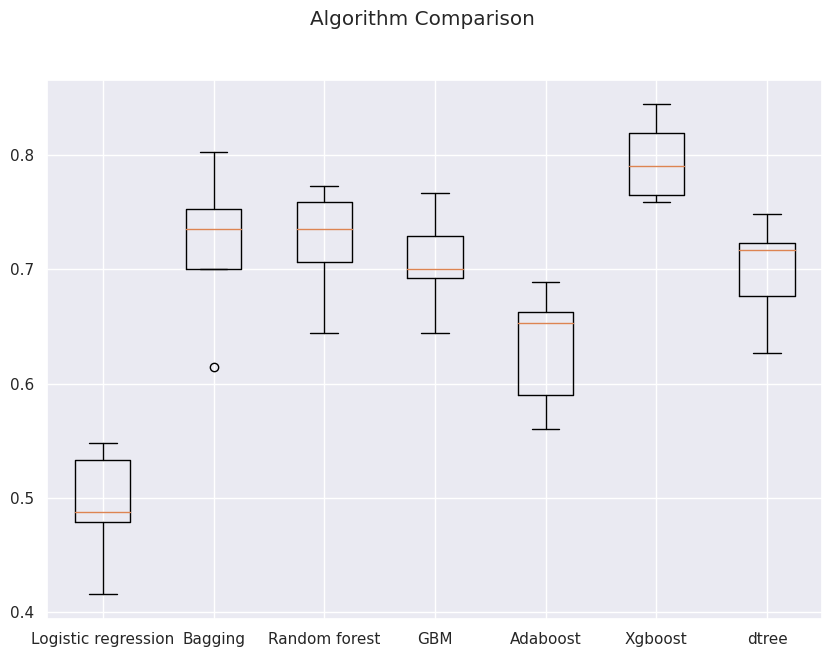

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

XGBoost has the highest level of Recall using undersampled data, followed by bagging and then random forest

**After looking at performance of all the models, let's decide which models can further improve with hyperparameter tuning.**

**Note**: You can choose to tune some other model if XGBoost gives error.

## Hyperparameter Tuning

### Tuning AdaBoost using oversampled data

In [ ]:
%%time

# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.9714853746337214:
CPU times: user 2min 38s, sys: 8.05 s, total: 2min 46s
Wall time: 1h 40s


In [ ]:
# Creating new pipeline with best parameters
tuned_ada = AdaBoostClassifier(
    n_estimators= 200,
    learning_rate= 0.2,
    base_estimator= DecisionTreeClassifier(max_depth=3, random_state=1)
)

#fitting the model on training data
tuned_ada.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=0.2, n_estimators=200)

In [ ]:
ada_train_perf = model_performance_classification_sklearn(tuned_ada, X_train_over, y_train_over)
ada_train_perf

,Accuracy,Recall,Precision,F1
0,0.948,0.897,1.000,0.946


In [ ]:
ada_val_perf = model_performance_classification_sklearn(tuned_ada, X_val, y_val)
ada_val_perf

,Accuracy,Recall,Precision,F1
0,0.985,0.755,0.972,0.850


### Tuning Random forest using undersampled data

In [ ]:
%%time

# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)}


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 250, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.6996248466921577:
CPU times: user 39 s, sys: 1.98 s, total: 41 s
Wall time: 27min 14s


In [ ]:
# Creating new pipeline with best parameters
tuned_rf2 = RandomForestClassifier(
    max_features= 'sqrt',
    random_state=1,
    max_samples=0.6,
    n_estimators=250,
    min_samples_leaf=1,
)

tuned_rf2.fit(X_train, y_train)

RandomForestClassifier(max_samples=0.6, n_estimators=250, random_state=1)

In [ ]:
rf2_train_perf = model_performance_classification_sklearn(tuned_rf2, X_train_over, y_train_over)
rf2_train_perf

,Accuracy,Recall,Precision,F1
0,0.905,0.811,1.000,0.896


In [ ]:
rf2_val_perf = model_performance_classification_sklearn(tuned_rf2, X_val, y_val)
rf2_val_perf

,Accuracy,Recall,Precision,F1
0,0.983,0.712,0.985,0.827


### Tuning Gradient Boosting using oversampled data

In [ ]:
%%time

# defining model
Model = GradientBoostingClassifier(random_state=1)

#Parameter grid to pass in RandomSearchCV
param_grid={"n_estimators": np.arange(100,150,25), "learning_rate": [0.2, 0.05, 1], "subsample":[0.5,0.7], "max_features":[0.5,0.7]}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, scoring=scorer, n_iter=50, n_jobs = -1, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 1} with CV score=0.9723322092856124:
CPU times: user 31.7 s, sys: 1.47 s, total: 33.2 s
Wall time: 27min 15s


In [ ]:
# Creating new pipeline with best parameters
tuned_gbm = GradientBoostingClassifier(
    max_features=0.5,
    random_state=1,
    learning_rate=1,
    n_estimators=125,
    subsample=0.7,
)

tuned_gbm.fit(X_train_over, y_train_over)

GradientBoostingClassifier(learning_rate=1, max_features=0.5, n_estimators=125,
                           random_state=1, subsample=0.7)

In [ ]:
gbm_train_perf = model_performance_classification_sklearn(tuned_gbm, X_train_over, y_train_over)
gbm_train_perf

,Accuracy,Recall,Precision,F1
0,0.993,0.992,0.994,0.993


In [ ]:
gbm_val_perf = model_performance_classification_sklearn(tuned_gbm, X_val, y_val)
gbm_val_perf

,Accuracy,Recall,Precision,F1
0,0.969,0.856,0.678,0.757


### Tuning XGBoost using oversampled data

**Note**: You can choose to skip this section if XGBoost gives error.

In [ ]:
%%time

# defining model
Model = XGBClassifier(random_state=1,eval_metric='logloss')

#Parameter grid to pass in RandomSearchCV
param_grid={'n_estimators':[150,200,250],'scale_pos_weight':[5,10], 'learning_rate':[0.1,0.2], 'gamma':[0,3,5], 'subsample':[0.8,0.9]}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 250, 'learning_rate': 0.1, 'gamma': 3} with CV score=0.858206478609047:
CPU times: user 1min 16s, sys: 3.66 s, total: 1min 20s
Wall time: 1h 22min 43s


In [ ]:
xgb2 = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.8,
    scale_pos_weight=10,
    n_estimators=250,
    learning_rate=0.1,
    gamma=3,
)

xgb2.fit(X_train_over, y_train_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=3, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1, ...)

In [ ]:
xgb2_train_perf =  model_performance_classification_sklearn(xgb2, X_train_over, y_train_over)
xgb2_train_perf

,Accuracy,Recall,Precision,F1
0,0.999,1.000,0.998,0.999


In [ ]:
xgb2_val_perf = model_performance_classification_sklearn(xgb2, X_val, y_val)
xgb2_val_perf

,Accuracy,Recall,Precision,F1
0,0.980,0.885,0.783,0.831


**We have now tuned all the models, let's compare the performance of all tuned models and see which one is the best.**

## Model performance comparison and choosing the final model

In [ ]:
# training performance comparison
models_train_comp_df = pd.concat(
    [
        gbm_train_perf.T,
        ada_train_perf.T,
        rf2_train_perf.T,
        xgb2_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Gradient Boosting tuned with oversampled data",
    "AdaBoost classifier tuned with oversampled data",
    "Random forest tuned with undersampled data",
    "XGBoost tuned with oversampled data",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Gradient Boosting tuned with oversampled data,AdaBoost classifier tuned with oversampled data,Random forest tuned with undersampled data,XGBoost tuned with oversampled data
Accuracy,0.993,0.948,0.905,0.999
Recall,0.992,0.897,0.811,1.000
Precision,0.994,1.000,1.000,0.998
F1,0.993,0.946,0.896,0.999


In [ ]:
# validation performance comparison
models_val_comp_df = pd.concat(
    [
        gbm_val_perf.T,
        ada_val_perf.T,
        rf2_val_perf.T,
        xgb2_val_perf.T,

        #gbm_random_val.T,
        #dt_grid_val.T,
        #dt_random_val.T
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "Gradient Boosting Tuned with Grid search",
    "AdaBoost Tuned with Grid search",
    "Random forest tuned with Grid search",
    "XGBoost tuned with Grid search",

    #"AdaBoost Tuned with Random search",
    #"Gradient Boosting Tuned with Random search",
    #"Decision tree with grid search",
    #"Decision tree with random search",
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Gradient Boosting Tuned with Grid search,AdaBoost Tuned with Grid search,Random forest tuned with Grid search,XGBoost tuned with Grid search
Accuracy,0.969,0.985,0.983,0.980
Recall,0.856,0.755,0.712,0.885
Precision,0.678,0.972,0.985,0.783
F1,0.757,0.850,0.827,0.831


**Now we have our final model, so let's find out how our final model is performing on unseen test data.**

In [ ]:
#check the performance on test set
gbm_grid_test = model_performance_classification_sklearn(tuned_gbm, X_test, y_test)
print("Test performance:")
gbm_grid_test

Test performance:


,Accuracy,Recall,Precision,F1
0,0.965,0.840,0.648,0.731


### Feature Importances

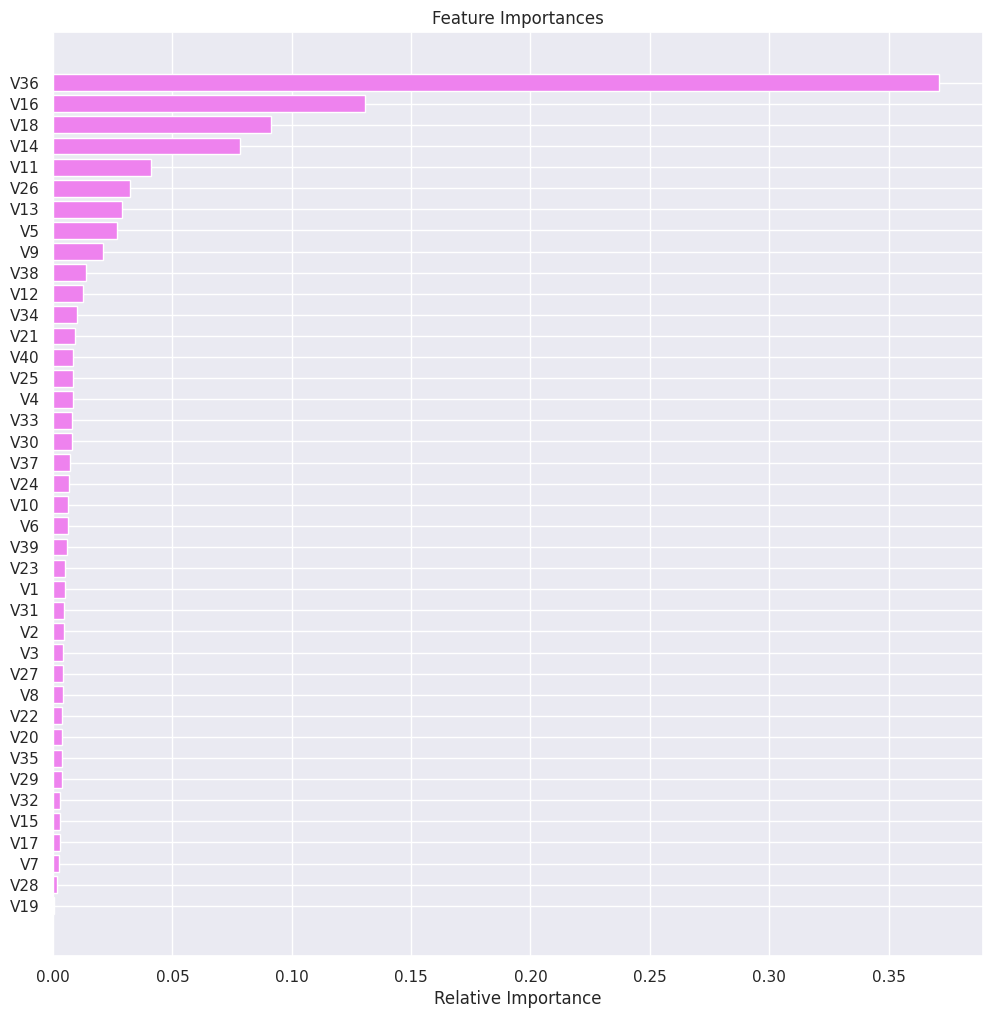

In [ ]:
feature_names = X_train.columns
importances =  tuned_gbm.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

## Let's use Pipelines to build the final model

- Since we have only one datatype in the data, we don't need to use column transformer here

In [ ]:
Pipeline_model = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

In [ ]:
# Separating target variable and other variables
X1 = data_train.drop(columns="Target")
Y1 = data_train["Target"]

# Since we already have a separate test set, we don't need to divide data into train and test

X_test1 = data_test.drop(columns="Target")
y_test1 = data_test["Target"]


In [ ]:
# We can't oversample/undersample data without doing missing value treatment, so let's first treat the missing values in the train set
imputer = SimpleImputer(strategy="median")
X1 = imputer.fit_transform(X1)

# We don't need to impute missing values in test set as it will be done inside pipeline

**Note:** Please perform either oversampling or undersampling based on the final model chosen.

If the best model is built on the oversampled data, uncomment and run the below code to perform oversampling

In [ ]:
#oversampling on the data - Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_over1, y_over1 = sm.fit_resample(X1, Y1)

If the best model is built on the undersampled data, uncomment and run the below code to perform undersampling


In [ ]:
# # code for undersampling on the data
# # Under Sampling Technique
# rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
# X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [ ]:
Pipeline_model.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [ ]:
Pipeline_model_test = model_performance_classification_sklearn(model, X_test, y_test)
Pipeline_model_test

,Accuracy,Recall,Precision,F1
0,0.963,0.713,0.663,0.687


# Business Insights and Conclusions


* The best model for this project is the XGBoost model since it has the highest recall amongst the original data, oversampled data, and undersampled data amongst the models that were tested.

* V36, V16, and V18 are the most important variables to determing whether or not a wind turbine needs maintance or not.

* Because th variables in ReneWind are unknown, it's hard to pull insights for the business. However, from the data, we can see that the variable V36 has the highest impact on the maintance of the wind turbines.

In [ ]:
! pwd

/content


In [ ]:
%%shell
jupyter nbconvert /content/Heerdink_Noah_ReneWind.ipynb --to html

[NbConvertApp] Converting notebook /content/Heerdink_Noah_ReneWind.ipynb to html
[NbConvertApp] Writing 2774309 bytes to /content/Heerdink_Noah_ReneWind.html
